# purpose: readin cleaned & epoched pupil data, ran stat tests and generate figures
previous: cleanELPup.ipynb and cleanELSacc.ipynb

permutation:
- within block reliability: for high, med, low, comparing bright vs dark seperately. 
- across block reliability: downsample the data, then get  the block x item brightness interaction.
- generate null distribution, compare real p value to null. 

plot
- grand average plot: generated using custom function pupilPlot. shows the average pupil size during retrocue and delay.
- difference score: for each block reliability condition, take dark - bright mean.
- vviq: break the imagers into 3 roughly equal size bins, plot the pupil average. Take mean pupil size during delay, for dark - bright for each subject.

Behavior
- shows the results from psychopy 


upnext: saccResults.ipynb

In [1]:
import warnings
warnings.filterwarnings("ignore")
#for handling RAM
import gc 

#stats
from statsmodels.stats.anova import AnovaRM
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.formula.api import ols
import pingouin as pg


#my to go packages
import math
import random
import pandas as pd
import numpy as np

#plotting
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from matplotlib.gridspec import GridSpec
from matplotlib import cm
import matplotlib.ticker as ticker
from matplotlib.colors import LinearSegmentedColormap


#for readin
import glob # Package for Unix-style pathname pattern expansion
import os   # Python operating system interface

#for signal processing
from scipy.interpolate import CubicSpline,interp1d
import scipy.signal as signal
import scipy.stats as stats
from scipy.signal import filtfilt, butter
from scipy.fft import rfft, rfftfreq
from scipy.stats import sem 
from scipy.stats import norm
from scipy.stats import ttest_rel

#other packages
import ast
import itertools
from itertools import groupby
from more_itertools import consecutive_groups
import more_itertools as mit
from operator import itemgetter
import statistics
from sklearn.mixture import GaussianMixture



# functions

In [2]:
#helper functions for speed array
def find_abs_speed_noSmooth(timepoint,ps): #find the raw speed array without applying any smoothing

    ds = np.zeros(len(ps))

    try:
        ps = pd.to_numeric(ps, errors='coerce').fillna(0.0) #repleace non numeric values with 0
    except AttributeError:
        ps = np.where(np.isnan(ps),0,ps)
    
    try:
        ps = ps.values
        timepoint = timepoint.values
    except AttributeError:
        pass

    prev = abs((ps[1:-1] - ps[0:-2])/(timepoint[1:-1] -timepoint[0:-2]))
    post = abs((ps[1:-1] -ps[2:])/ (timepoint[1:-1] -timepoint[2:]))
               
    ds[1:-1] = np.where(prev >= post,prev,post)
    ds[0] = abs((ps[1] - ps[0])/ (timepoint[1] - timepoint[0]))
    ds[-1] = abs((ps[-1] - ps[-2])/ (timepoint[-1] - timepoint[-2]))
    
    return ds
def find_abs_speed_pup(ps): #this is same as find_abs_speed, but now using a smoothed speed array for pupil
    #by using 5 points to calculate speed instead of 2
    ds = np.zeros(len(ps))

    try:
        ps = pd.to_numeric(ps, errors='coerce').fillna(0.0) #repleace non numeric values with 0
    except AttributeError:
        ps = np.where(np.isnan(ps),0,ps)
    
    try:
        nminus1 = ps.iloc[1:-3].values
        nplus1 = ps.iloc[3:-1].values
        nminus2 = ps.iloc[0:-4].values
        nplus2 = ps.iloc[4:].values

        ds[0] = abs(ps.iloc[1] - ps.iloc[0])
        ds[1] = abs(ps.iloc[2] - ps.iloc[1])
        ds[-1] = abs(ps.iloc[-1] - ps.iloc[-2])
        ds[-2] = abs(ps.iloc[-2] - ps.iloc[-3])
    except AttributeError:
        nminus1 = ps[1:-3]
        nplus1 = ps[3:-1]
        nminus2 = ps[0:-4]
        nplus2 = ps[4:]

        ds[0] = abs(ps[1] - ps[0])
        ds[1] = abs(ps[2] - ps[1])
        ds[-1] = abs(ps[-1] - ps[-2])
        ds[-2] = abs(ps[-2] - ps[-3])
               
    ds[2:-2] = abs((nplus1 + nplus2- nminus1 - nminus2  )/6)
    
    
    return ds
def find_abs_speed_sacc(vec):#this is same as find_abs_speed, but now using a smoothed speed array,for saccade 
    # because we're using.iloc and .values, need to make sure the 
    # vec input is from dataframe
    try:
        nminus1 = vec.iloc[1:-3].values
        nplus1 = vec.iloc[3:-1].values
        nminus2 = vec.iloc[0:-4].values
        nplus2 = vec.iloc[4:].values
    except AttributeError:
        nminus1 = vec[1:-3]
        nplus1 = vec[3:-1]
        nminus2 = vec[0:-4]
        nplus2 = vec[4:]
    #calculate derivative
    d = (nplus1 + nplus2- nminus1 - nminus2  )/6

    return d

In [3]:
#other helper functions
def consecutive(data, stepsize=10,
                findSame = False): # helper function for findGazeShift, deBlink, and more
    """
    @ data = row vector
    @ stepsize =  the larger the step size, the more difference it allows for two groups
                to be considered within the same cluster
    @ findSame = if True, find concecutive data point of the same value, this is set true
                 for finding blink counts using the blink mask (a df of 0 and 1 )
    """
    # this will split an array of numbers into many subarrays of consecutive numbers
    # the stepsize controls for how close of the two numbers for them to be considered
    # in the same cluster; e.g. [1,2,3,4,5,10] would be clustered together if stepsize = 5

    #data is the array of timepoint where the saccade velocity array crossed the threshold
    if findSame:
        stepsize = 0
        return np.split(data, np.where(abs(np.diff(data)) > stepsize)[0]+1)
    return np.split(data, np.where(np.diff(data) > stepsize)[0]+1)
def smooth(x,window_len=11,window='hanning'): #smoothing function
    try:
        x = x.values
    except:
        pass
    # about np windows:
    # https://numpy.org/doc/stable/reference/routines.window.html
    if x.ndim != 1:
        raise ValueError("smooth only accepts 1 dimension arrays.")

    if x.size < window_len:
        raise ValueError("Input vector needs to be bigger than window size.")

    if window_len<3:
        return x

    if not window in ['flat', 'hanning', 'hamming', 'bartlett', 'blackman']:
        raise ValueError("Window is on of 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'")

    #this is to prepare the input for convolve i.e. add 1/2 window length padding before and after
    s=np.r_[x[window_len-1:0:-1],x,x[-2:-window_len-1:-1]] 
    
    if window == 'flat': #moving average
        w=np.ones(window_len,'d')
    else:
        w=eval('np.'+window+'(window_len)')

    #sliding window
    y=np.convolve(w/w.sum(),s,mode='valid')
    
    #get rid of the paddings
    return y[int(window_len/2):int(-0.5*window_len)] #select the data points to get rid of the delay
def strictly_increasing(L):#check if an array is uniformly increasing
    return all(x<y for x, y in zip(L, L[1:]))
def fs(width,height):#setting plot size
    plt.rcParams['figure.figsize'] = (width,height)


In [4]:
#function used for blink identification
def mad_func(ds,mad_threshold): #calculate the median absolute diviation (MAD)
    
    """
    function that calculate the median absolute diviation (MAD)
    ---------------------------------------------
    input: 
    ds: median absolute dilation speed, which is calculated in dilation_speed_filter
    mad_threshold: the threshold of median deviation (MAD); any data that is above median dilation speed + threshold*(MAD) will be rejected
    ---------------------------------------------
    output:
    returns a float and a boolean, first is the threshold, second is the bool array
    """
    try:
        ds = np.where(np.isnan(ds),0,ds)
    except:
        ds = np.where(ds.isnull(),0,ds)
    mad = np.nanmedian(abs(ds - np.nanmedian(ds))) # median absolute deviation
    rej_threshold = np.median(ds) + mad_threshold * mad # reject data above this threshold
       
    #returning an bool array, true = rejected, false = keep
    return (abs(ds) >= rej_threshold)  , rej_threshold
def reject_outlier(pt,rejarr, minGapLen = 0.03, borderlen = 0.05, borderlenBefore = 0,
                   freq = 1000): # 
    """
  
    ---------------------------------------------
    input:
    pt: pupil timestamps from pup_raw
    rejarr: pupil diameter with nans, assigning nan to the pupil array using the output of dilation_speed_filter()
    ---------------------------------------------
    output: return a dictionary, each key is the starting time of the nan value, each value is the end time of nan
    
    """
    borderN = borderlen* freq #number of adjacent data points that needs to be rejected
    borderNbefore = borderlenBefore * freq
    gapMinN = minGapLen * freq #number of data points in the gap
    
    b = np.where(rejarr==True, np.nan,rejarr)
    idx0 = np.flatnonzero(np.r_[True, np.diff(np.isnan(b))!=0,True])
    count = np.diff(idx0)
    idx = idx0[:-1]
    valid_mask =  np.isnan(b[idx])
    out_idx = idx[valid_mask]
    out_count = count[valid_mask]
    m = out_idx + out_count-1
    out = list(zip(out_idx, m))

    if len(out) == 0:
        return out

    #if the number of consecutively rejected data satisfies as a gap, record it
    outbool = np.array([(out[i][-1] - out[i][0])> gapMinN for i in range(len(out))])
    conRejarr = np.array(out)[outbool]
    gapCorrarr = [[]]*len(conRejarr)
    
    for i in range(len(conRejarr)):
        conRejarr[i][0] = max(0,conRejarr[i][0]-borderNbefore)
        #print(conRejarr[i][-1],conRejarr[i][-1]+borderN)
        conRejarr[i][-1] = min(len(pt)-1,conRejarr[i][-1]+borderN)
        gapCorrarr[i] = np.arange(conRejarr[i][0],conRejarr[i][-1]+1)
   
    return np.array(gapCorrarr)
def blkLen(rowInput,blkLen):#counts how many blink has occured using the mask df
    #blink len default = how many consecutive points for one event to be registered as blink
    #count this as 1 blink event
    boolMask = [list(g)[0]>0 for k, g in groupby(rowInput) ]
    repeatingVal = np.array([list(g) for k, g in groupby(rowInput)])
    
    blkArr = repeatingVal[boolMask]
    blkCnt = sum([len(i) > blkLen for i in blkArr])
    return blkCnt
def medianVariance(vec):#vec is the result from find_abs_speed_pup/sacc
    try:
        val = np.nanmedian(abs(vec - np.nanmedian(vec)))
    except:
        print('F**k! medianVariance function encountered an error:')
        print('dtype of vec:' + str(type(vec)))
        print('np.nanmedian(vec) :' + str(np.nanmedian(vec)))
    return val

In [5]:
#older functions
def interpolate_blink(paddedRejIndex,paddedRejBool, timestamp,pupilsize,
                      maxGapLen = 0.5,freq = 200):#paddedRejIndex = output from reject_outlier; ..Bool is the pseudodf['paddedDsRej']
    # check for the length for each gap, if it's longer than the maximum length defined for a gap
    # then don't interpolate, just leave it blank
    interpolateIndex = paddedRejIndex[[len(i)<maxGapLen*freq for i in paddedRejIndex]]
    """ i found that it works better to not smooth the pupil size
     """
    pupilsize = np.array(smooth(pupilsize))
   
    #for each blink, select the onset/offset pupil size, as well as two equal distant time point,call it ref list
    refList = np.array([np.array([max(0,i[0] - len(i)),i[0],i[-1],min(len(timestamp)-1,i[-1] + len(i))]) for i in interpolateIndex])
    
    #use the refList to retrieve the paddedRejIndex, if more than 2 values are True, i.e. the first and last reference points
    #are also rejected data, then use the linear interpolation, else if the first and last ref points can be retrieved,
    #use cubic spline interpolation
    linearList = refList[np.sum(paddedRejBool.values[refList],axis = 1) > 2]
    cubicList = refList[np.sum(paddedRejBool.values[refList],axis = 1)== 2]
    
    #use the linearlist or cubic list, find the timestamp or pupilsize values used for interpolation
    cubictss = timestamp.values[cubicList]
    cubicarr = pupilsize[cubicList]#pupilsize.values[cubicList]
    
    lineartss = timestamp.values[linearList]
    lineararr = pupilsize[linearList]#pupilsize.values[linearList]
    
    #calculate the interpolated values; Index is the array of timestamp arrays, FuncList is the interpolated value
    cubicIndex = [np.array(timestamp.iloc[cubicList[i][1]:cubicList[i][2]]) for i in range(len(cubicList))]
    csFuncList = [CubicSpline(cubictss[i],cubicarr[i])(cubicIndex[i]) for i in range(len(cubicList))]

    linearIndex = [np.array(timestamp.iloc[linearList[i][1]:linearList[i][2]]) for i in range(len(linearList))]
    lFuncList = [interp1d(lineartss[i],lineararr[i])(linearIndex[i]) for i in range(len(linearList))]
   
    return cubicIndex,csFuncList,linearIndex,lFuncList
def dsclean(thisdf,arr):
    """
    this is the main function for reject, clean, and interpolate
    thisdf is the df of the specific subject
    #1st it, arr = 'diameter_3d', 2+ it, arr = 'diameter_3dNew'
    
    note: outside the function, these four variables needs to be specified, e.g.
    maxGapLen = 1; minGapLen = 0.0 ; freq = 1000; gapMinN = minGapLen*freq; gapMaxN = maxGapLen*freq
    
    
    """
    #1st ite
    arr = thisdf[arr] #1st it, arr = diameter_3d, 2+ it, arr = diameter_3dNew
    rejarr,rejThreshold = mad_func(find_abs_speed(thisdf.pupil_timestamp,arr),3.5)    #need to get rid of zeros
    thisdf['dsRej'] = (rejarr == True) | (arr.isnull()) | (arr == 0)

    paddedDsRej = reject_outlier(thisdf.pupil_timestamp,thisdf.dsRej,minGapLen = minGapLen,borderlen=0.025,freq= 1000)
    thisdf['paddedDsRej'] = np.where(thisdf.index.isin(np.concatenate(paddedDsRej)),True,False)

    gapCorrarr = np.where(thisdf.paddedDsRej)[0]
    #the sum of sublist in gapCorrarrparsed is the same length as the gapCorrarr
    gapCorrarrParsed = [np.array(list(group)) for group in mit.consecutive_groups(gapCorrarr)] 

    #if the gap is shorter than minimum length, don't count it as a gap (but i've set min gap len to 0)
    outbool = np.array([(gapCorrarrParsed[i][-1] - gapCorrarrParsed[i][0])> gapMinN for i in range(len(gapCorrarrParsed))])
    gapCorrarrParsed = np.array(gapCorrarrParsed)[outbool]
    #correct the paddedDsRej, excluding shorter-than-gap values, i.e. set those to false
    thisdf['paddedDsRejNoGap'] = np.where(thisdf.index.isin(np.concatenate(gapCorrarrParsed)),True,False)

    #also don't interpolate for gap length longer than maximum gap len
    #first iteration use diameter 3d
    csts,csi,lts,li = interpolate_blink(paddedRejIndex = gapCorrarrParsed,
                                        paddedRejBool = thisdf['paddedDsRejNoGap'],
                                        timestamp = thisdf.pupil_timestamp,
                                        pupilsize = arr,
                                        freq = 1000) #this pupilsize is different for iteretions

    #for this 1st iteration, make a copy of diameter 3d to add the interpolated data
    thisdf['diameterThisIter'] = arr #this pupilsize is different for iteretions
    try:
        thisdf.loc[np.where(thisdf['pupil_timestamp'].isin(np.concatenate(csts)))[0],'diameterThisIter'] = np.concatenate(csi)
        thisdf.loc[np.where(thisdf['pupil_timestamp'].isin(np.concatenate(lts)))[0],'diameterThisIter'] = np.concatenate(li)
    except ValueError: 
        print('no array to concat')
    """
    minPup = np.mean(thisdf['diameterThisIter']) - 3*np.std(thisdf['diameterThisIter'])
    maxPup = np.mean(thisdf['diameterThisIter']) + 3*np.std(thisdf['diameterThisIter'])

    #also reject periods of pupil size that's larger the 3 sd away from the median, callit diameter_3dNew
    thisdf['diameter_3dNew'] = np.where(((thisdf['diameterThisIter']<minPup)|(thisdf['diameterThisIter']>maxPup)),0, thisdf['diameterThisIter'] )
    """
    return thisdf
def tlclean(thisdf,windown = 501,mad = 10,
            psCol = 'diameterThisIter',tsCol = 'pupil_timestamp',psColNew = 'diameter_3dNew'):
    
    #make trendline by interpolating and smoothing
    cs = CubicSpline(thisdf[tsCol][~thisdf[psCol].isnull()].values,
                   thisdf[psCol][~thisdf[psCol].isnull()].values)
    interp = cs(thisdf[tsCol])
    smoothed = smooth(interp,windown)
    #tlmad = bool list
    tlmad = mad_func(thisdf[psCol] -smoothed,mad)[0]
    thisdf['dsRej'] = (tlmad == True) | (thisdf[psCol].isnull() == True) | (thisdf[psCol] == 0)

    #don't pad the tl deviations
    arr = thisdf[psCol]
    gapCorrarr = (np.where(thisdf.dsRej)[0]) 
    #the sum of sublist in gapCorrarrparsed is the same length as the gapCorrarr
    gapCorrarrParsed = np.array([np.array(list(group)) for group in mit.consecutive_groups(gapCorrarr)]) 

    #preparation for interpolation
    interpolateIndex = gapCorrarrParsed[[len(i)<maxGapLen*freq for i in gapCorrarrParsed]]
    refList = np.array([np.array([max(0,i[0] - len(i)),i[0],i[-1],min(len(thisdf[tsCol])-1,i[-1] + len(i))]) for i in interpolateIndex])
    increasingList = np.array([strictly_increasing(i) for i in refList])

    linearList = refList[(np.sum(thisdf['dsRej'].values[refList],axis = 1) > 2) | (increasingList== False) ]
    cubicList = refList[(np.sum(thisdf['dsRej'].values[refList],axis = 1)== 2) & (increasingList)]

    #use the linearlist or cubic list, find the thisdf[tsCol] or arr values used for interpolation
    cubictss = thisdf[tsCol].values[cubicList]
    cubicarr = arr.values[cubicList]
    #correct for nan
    cubicList = cubicList[np.isnan(cubicarr).sum(axis = 1) !=1]##
    cubictss = cubictss[np.isnan(cubicarr).sum(axis = 1) !=1]##
    cubicarr = cubicarr[np.isnan(cubicarr).sum(axis = 1) !=1] ##

    #for linear
    lineartss = thisdf[tsCol].values[linearList]
    lineararr = arr.values[linearList]
    #correct for nan
    linearList = linearList[np.isnan(lineararr).sum(axis = 1) !=1]##
    lineartss = lineartss[np.isnan(lineararr).sum(axis = 1) !=1]##
    linearr = lineararr[np.isnan(lineararr).sum(axis = 1) !=1] ##


    #calculate the interpolated values; Index is the array of thisdf[tsCol] arrays, FuncList is the interpolated value
    cubicIndex = [np.array(thisdf[tsCol].iloc[cubicList[i][1]:cubicList[i][2]]) for i in range(len(cubicList))]
    csFuncList = [CubicSpline(cubictss[i],cubicarr[i])(cubicIndex[i]) for i in range(len(cubicList))]

    linearIndex = [np.array(thisdf[tsCol].iloc[linearList[i][1]:linearList[i][2]]) for i in range(len(linearList))]
    lFuncList = [interp1d(lineartss[i],lineararr[i])(linearIndex[i]) for i in range(len(linearList))]

    #for this 1st iteration, make a copy of diameter 3d to add the interpolated data
    thisdf[psColNew] = arr #copy the old ps column, then modify it using the interpolated values
    thisdf.loc[np.where(thisdf[tsCol].isin(np.concatenate(cubicIndex)))[0],psColNew] = np.concatenate(csFuncList)
    thisdf.loc[np.where(thisdf[tsCol].isin(np.concatenate(linearIndex)))[0],psColNew] = np.concatenate(lFuncList)
    
    return thisdf
def tl(thisdf,windown = 501,mad = 10,
       psCol = 'diameterThisIter',tsCol = 'pupil_timestamp',psColNew = 'diameter_3dNew'):
    #make trendline by interpolating and smoothing
    cs = CubicSpline(thisdf[tsCol][~thisdf[psCol].isnull()].values,
                   thisdf[psCol][~thisdf[psCol].isnull()].values)
    interp = cs(thisdf[tsCol])
    smoothed = smooth(interp,windown)
    #tlmad = bool list
    tlmad = mad_func(thisdf[psCol] -smoothed,mad)[0]
    return tlmad
def tlFinal(x,y,windown = 101,mad = 10):
    #this is for doing trialwise tl rejection, not very necessay but since the input format
    #is slightly different from the tl function, i'm including it as a sepearte one
    cs = CubicSpline(x[~np.isnan(y)],
                    y[~np.isnan(y)])
    interp = cs(x)
    smoothed = smooth(interp,windown)
    #tlmad = bool list
    tlmad = mad_func(y-smoothed,mad)[0]
    return tlmad

In [6]:
#core functions
def deBlink(rawPup,timestamp,
            returnMask = False,
            maxGapt = 2,
            minGapt= 0.003,
            freq = 1000,
            borderlenBef=0.001,
            borderlenAft=0.01,
            clusterLapse = 0.15,
            plotSteps = False,
            madThreshold = 3.5,
            minPupAllowed = 2000
            ):
    """
    #this function clean the pupil array, and generate a boolean blink mask array
    @ rawPup = each row in the epoched pupil table
    @ timestamp = 
    @ returnMask: if true, return the boolean mask only (this is necessday because df.apply can't return two dfs)
    @ minGapt = 
    @ freq = 
    @ borderlenBef = paddings to add after each blink
    @ borderlenAft = paddings to add before each blink
    @ clusterLapse = larger value will count more distant blinks as one, resulting in more data rejected
    @ plotSteps = if True, generate a plot for the cleaning step
    @ madThreshold = speed threshold for rejection
    @ minPupAllowed = the min pupil size allowed for it to not be classified as err
    """
    #find the raw rej arr; This use a smoothed pupil change speed array to find the threshold
    #crossings
    rejarr = mad_func(find_abs_speed_pup(rawPup),madThreshold)[0] | (rawPup < minPupAllowed)

    #initialize two mask array, these will store the processed blink mask
    rejarr_padded = np.zeros(len(rejarr))
    rejarr_blkMask = np.zeros(len(rejarr))

    #pad the mask
    try:
        np.put(rejarr_padded, np.concatenate(reject_outlier(timestamp, rejarr, minGapLen= minGapt,freq = freq,
                                                             borderlenBefore=borderlenBef,
                                                    borderlen=borderlenAft)), 1, mode='clip')
    except ValueError:
        rejarr_padded = rejarr

    #identify clusters in the mask (if two blink are too close, count them as one cluster and mask off the lapse between)
    #put the resulting mask into rejarr_blkMask, this will be returned as output
    try:
        consecutiveBlkFilter = np.array([np.arange(i[0], i[-1]+1) for i in consecutive(np.where(rejarr_padded)[0], 
                                                                                       stepsize= clusterLapse*freq)])
        np.put(rejarr_blkMask, np.concatenate(consecutiveBlkFilter), 1, mode='clip')
    except ValueError:
        rejarr_blkMask = rejarr_padded
    except IndexError: 
        return rawPup
        
    blkMask = rejarr_blkMask.copy()

    #just return the mask if necessary
    if returnMask:
        return blkMask

    """clean"""
    #use this mask to clean the pupil, mask off the data in blink
    #creating a copy for the plot because we will change the value of maskedPup 
    maskedPup_plt = np.where(rejarr_blkMask, np.nan, rawPup) 
    maskedPup = maskedPup_plt.copy() 

    """interpolation"""
    # reshape the clusted blink mask into arrays of clusted index, if its lenth if larger than the 
    # maximum gap lenth * frequency, then don't interpolate for this cluster, just leave it blank
    rejCluster = consecutive(np.where(rejarr_blkMask)[0], 1)
    rejCluster = np.array([k for k in rejCluster if len(k) < maxGapt*freq])

    #find four index for interpolation
    indexForInterp = np.array([np.array([max(0, i[0] - len(i)),
                                        max(0, i[0]-1),
                                        min(i[-1]+1, len(timestamp)-1),
                                        min(len(timestamp)-1, i[-1] + len(i))]) for i in rejCluster])
    
    #when applying this function to a df, sometime it required the input to be in specific format
    try:
        timestamp = timestamp.values
        rawPup = rawPup.values
    except AttributeError:
        timestamp = np.array(timestamp)
        rawPup = np.array(rawPup)
    
    #run the following if there there are available blink clusters for interpolation, interpolate
    try:
        #get the timestamp and pupil size (masked) for creating the interpolation function
        tsForInterp = timestamp[indexForInterp]
        cleanPupForInterp = maskedPup[indexForInterp]
        
        #get the timestemp for exptrapolate the missing pupil size
        tsForExtrap = [timestamp[i] for i in rejCluster]
        
        #for each available blink cluster,try use the cubic spline interpolation of 4 points
        #but if any point if nan, then use linear; but if it still can't (e.g. only one data point availble)
        #then don't interpolate, leave it as nan
        for i in range(len(rejCluster)):
            try:
                pupExtrapolated = CubicSpline(tsForInterp[i], cleanPupForInterp[i])(tsForExtrap[i].astype(float))
            except ValueError:
                try:  # if cant find reference points, use linear interpolation
                    pupExtrapolated = interp1d(tsForInterp[i][1:3], cleanPupForInterp[i][1:3])(tsForExtrap[i].astype(float))
                # if still gives error, then dont interpolate (usually the case with trial start/end)
                except ValueError:
                    pupExtrapolated = np.nan
            #fill each blink cluster with interpolated pupil value
            maskedPup[rejCluster[i]] = pupExtrapolated
    except IndexError:
        pass

    if plotSteps:
        fig, ax = plt.subplots(nrows=5)
        #plot speed and threshold of rejection
        sns.scatterplot(x= timestamp, y= find_abs_speed_pup(rawPup), ax=ax[0])
        ax[0].hlines(mad_func(find_abs_speed_pup(rawPup), 3.5)[1],
                    xmin=timestamp[0], xmax=timestamp[-100], colors='r')
        #plot the unfilted mask
        sns.scatterplot(x=timestamp, y=rawPup, hue=rejarr, ax=ax[1])
        #plot the filtered mask
        sns.scatterplot(x=timestamp, y=rawPup, hue=rejarr_blkMask, ax=ax[2])
        #plot the pupil data after it's been masked
        sns.scatterplot(x=timestamp, y=maskedPup_plt, ax=ax[3])
        #plot the interpolated pupil size
        sns.scatterplot(x=timestamp, y=maskedPup, ax=ax[4])
        
        ax[1].sharex(ax[0])
        ax[2].sharex(ax[0])
        ax[3].sharex(ax[0])
        ax[4].sharex(ax[0])

    
    return maskedPup
def findGazeShift(xvec,threshold = 6, countTogether = 50, 
                   baseline = None, winlen = 50,shiftmin = 2.14,
                   baselinePadding = 0):
    """
    @ xvec =  the gaze position (it should be each row in the saccRetro_X df)
    @ threshold = the velocity filter threshold
    @ countTogether = the maximum delay for two gaze shift cluster to be count as one
    @ baseline = if none, calculate relative baseline  (i.e. in regard to position before and after shift)
                else it should be a list of index to indicate baseline rage, e.g. [500,1000]
    @ winlen = for the onset of each identified gazeshift cluster, get the [-winlen,0] and [winlen, 2+ winlen]
            to calculate the mean gaze position before and after the shift occur
    @ shiftmin = the minimum shift in gaze position for it to be considered as a real shift
            default = 2.14 pixel = 0.057 visual degree
    @ baselinePadding = the padding to add before the identified gaze shift, this is only meaningful if baseline
                        is None (i.e. the shift regarding to gaze position before and after)
    
    """
    # get speed vector
    # since we are using 4 time points to calculate the speed array (see find abs speed sacc function)
    # the len of dx, dy is 4 points less than the length of xvec. 
    dx = find_abs_speed_sacc(xvec)
    #get threshold, then get a boolean array, for finding threshold crossing clusters
    thresholdx = [np.nanmedian(dx) + medianVariance(dx) *threshold,np.nanmedian(dx) - medianVariance(dx) *threshold]
    cx = (dx>thresholdx[0]) | (dx < thresholdx[1])
    cx = np.r_[False,False,cx,False,False] #correct for the four lost points


    # Deselect period at the beginning and the end of the position array i.e.掐头去尾
    # and re-identify the saccade cluster after applying both masks
    # if two clusteres are close enough (50ms), then count them as one
    onsetoffsetmask = np.r_[np.zeros(winlen + baselinePadding),np.ones(len(cx) - 3*winlen - 2* baselinePadding),np.zeros(2*winlen + baselinePadding)].astype(bool) #to deselect data in the first and last 50ms 
    maskedcx = np.where(cx & onsetoffsetmask)[0] 
    msCluster = consecutive(maskedcx,countTogether)

    # initialize the output array with zeros, calculate the mean pos before and after the shift
    gazeshift = np.zeros(len(xvec))    

    try:
        for i in msCluster:
            #if user doesn't provide a baseline value, use relative baseline
            if baseline == None:
                befIndex = [i[0] - winlen - baselinePadding,i[0]- baselinePadding]
            else:
                befIndex = baseline
            try:
                posbef = np.nanmean(xvec.iloc[befIndex[0] : befIndex[1]])
                posaft = np.nanmean(xvec.iloc[i[0] + winlen + baselinePadding : i[0] + 2*winlen + baselinePadding]) 

            except AttributeError: # this is to account for when using df.apply(raw = True),xvec is an array, not series
                posbef = np.nanmean(xvec[befIndex[0] : befIndex[1]])
                posaft = np.nanmean(xvec[i[0] + winlen + baselinePadding: i[0] + 2*winlen + baselinePadding]) 

            if abs(posaft - posbef) > shiftmin: 
                #toss away a ms if its less than a minimum visual degree 
                gazeshift[i[0]] = posaft - posbef 
            else:
                pass
    except IndexError: #i.e. if msCluster is empty, it gives error when trying to index i[0], in this case just return the 0 array
        return gazeshift
    return gazeshift

In [7]:

#this is originally used to linearly interpolate 
#missing saccade data
def linearInterpolate(x,y,method = 'linear'):
    """
    methods needs to be one of the scipy.interpolate.interp1d methods
    https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.interp1d.html
    """
    #if the entire trial is nan, return nan
    if np.isnan(np.array(y)).sum() == len(y):
        interp = np.empty(len(y))
        interp[:] = np.nan
        return interp
    #else,interpolate
    try:
        li = interp1d(x[~y.isnull()],
                        y[~y.isnull()],
                        fill_value="extrapolate",kind = method)
        interp = li(x)
    except AttributeError: #handling np.array and pandas df conversion
        li = interp1d(x[~np.isnan(y)],
                        y[~np.isnan(y)],fill_value="extrapolate",kind = method)
        
    interp = li(x)
    return interp

In [8]:
#plotting function
def legend_without_duplicate_labels(ax,locVal = 'best'):
    #https://stackoverflow.com/questions/19385639/duplicate-items-in-legend-in-matplotlib
    handles, labels = ax.get_legend_handles_labels()
    unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
    ax.legend(*zip(*unique),loc = locVal)
def deBlinkSample(rawPup, samplesize = 10): #plot n trial samples with the deblink process
    fs(12,12)
    select = np.random.randint(0,len(rawPup),size = samplesize)

    #select some smaple 
    sample_raw = rawPup.iloc[select,1:]

    #Clean once
    cleanOnceSample = sample_raw.apply(lambda x: deBlink(rawPup = x.astype(float),timestamp = np.linspace(0,5,len(x)),
                                                clusterLapse = 0.05, borderlenAft = 0.2,
                                                borderlenBef= 0.05,madThreshold = 4),axis = 1,raw = True)

    #second clean
    onceSmoothSample = cleanOnceSample.rolling(11,min_periods=1,center  = True,axis =1).mean()
    cleanTwiceSample = onceSmoothSample.apply(lambda x: deBlink(rawPup = x,timestamp = np.linspace(0,5,len(x)),
                                            borderlenBef = 0.05,borderlenAft = 0.05,minGapt = 0.002,
                                            clusterLapse = 0.05,madThreshold = 6),axis =1,raw = True)
    fig,ax = plt.subplots(nrows = 3)

    x = np.linspace(0,5,5000)
    [ax[0].plot(x,sample_raw.iloc[i,:],alpha = 0.8) for i in range(len(select))]
    [ax[1].plot(x,cleanOnceSample.iloc[i,:],alpha = 0.84,linewidth = 2) for i in range(len(select))]
    [ax[2].plot(x,cleanTwiceSample.iloc[i,:],alpha = 0.8,linewidth = 2) for i in range(len(select))]

    ax[1].set_ylim(ax[2].get_ylim())
    ax[0].set_ylim(ax[2].get_ylim())

    plt.show()
def pupilPlot(normPup,blPup, 
              eventt = 3,
              blt  = 0.1,
              freq = 1000,
              type = 'grand',
              levels = ['cue_blk_validity','cued_item'],
              pltRatio = [0.2,3], pltN = 3,
              eventBoundary = [0,0.5,2.5],
              eventName = ['retrocue','delay','probe'],
              blHeight = None,
              mainFigHeight = None,
              cList = [],
              figH = 5.5, figW = 16,
              tightPlot = True,
              textSize = 12,
              sigPeriod = None,
              sigAx = 0,
              sigBarHeight = 30,
              textOffset = 10,
              tickSize = 10
              ):
    """
    @ normPup = normalized pupil df with trial info columns in the end
    @ blPup = the pupil df with the baseline
    @ eventt = the time for the event of interest
    @ blLen = the time for the baseline
    @ freq = sampling frequency, defalut 1000
    @ type = the type of plot, 
           - grand avg: ;
           - subj avg: ;
    @ levels = the group by levels, e.g. block validity and cued item
    @ pltRatio = ratio for the plot for baseline and event
    @ pltN = how many plots, default 3
    @ eventBoundary = use to plot vertical lines on the plot to represent certain events
    @ eventName = the text label for these events
    @ blHeight = ylim for the baseline plots, if None, set ylim using max and min
    @ mainFigHeight = ylim for the main plots, if None, set ylim using max and min
    @ cList = the color list used for plots; default color- the ones i carefully preseletced, very pretty
    @ figH = figure height for each plot, default 5.5
    @ figW = figure width, default 16
    @ tightPlot = if true, set the plot layout to be tighter
    @ textSize = the text label on the plot size
    @ sigPeriod = 2 item list [start, end]
    @ sigAx = axes to draw the sigbar
    @ sigBarHeight = height of the significant bar, the larger the thicker
    @ textOffset = the height of text offset, the larger , the lower the text
    @ tickSize = size for ticks
    --------------
    return NormMean: the groupby df
    """
    eventLen = int(eventt*freq)
    blLen = int(blt*freq)

    if not type in ['grand','subj']:
        raise 'Your plot should either be grand avg or subj avg'
    if len(eventBoundary) != len(eventName):
        raise 'your event name array should be the same size as your event boundary(time) array'
    if type == 'grand':
        normmean = normPup.groupby(levels).mean().iloc[:,:eventLen]
        norm_sterr = normPup.groupby(levels).sem().iloc[:,:eventLen]
        norm_upper = normmean.iloc[:,:] +norm_sterr.iloc[:,:] 
        norm_lower = normmean.iloc[:,:] -norm_sterr.iloc[:,:] 

        normmeanBL = blPup.groupby(levels).mean().iloc[:,:blLen]
        norm_sterrBL = blPup.groupby(levels).sem().iloc[:,:blLen]
        norm_upperBL = normmeanBL.iloc[:,:] +norm_sterrBL.iloc[:,:] 
        norm_lowerBL = normmeanBL.iloc[:,:] -norm_sterrBL.iloc[:,:]

        #the mean df will be returned
        returnMean = normmean    
        returnSd = norm_sterr
    elif type == 'subj':
        subj_levels = levels + ['subj']
        normmean = normPup.groupby(subj_levels).mean().iloc[:,:eventLen].groupby(levels).mean()
        norm_sterr = normPup.groupby(subj_levels).mean().iloc[:,:eventLen].groupby(levels).sem()
        norm_upper = normmean.iloc[:,:] +norm_sterr.iloc[:,:] 
        norm_lower = normmean.iloc[:,:] -norm_sterr.iloc[:,:] 
        
        normmeanBL = blPup.groupby(subj_levels).mean().iloc[:,:blLen].groupby(levels).mean()
        norm_sterrBL = blPup.groupby(subj_levels).mean().iloc[:,:blLen].groupby(levels).sem()
        norm_upperBL = normmeanBL.iloc[:,:] +norm_sterrBL.iloc[:,:] 
        norm_lowerBL = normmeanBL.iloc[:,:] -norm_sterrBL.iloc[:,:]

        #the subj df will be returned
        returnMean = normPup.groupby(subj_levels).mean().iloc[:,:eventLen]
        returnSd =  normPup.groupby(subj_levels).sem().iloc[:,:eventLen]

    condN = normmean.shape[0]
    #if color list is not right length, use sns generated color
    if len(cList) < condN:
        print('input color list is too short, plot default color ')
        cList = sns.color_palette("flare",n_colors = condN)
     
    #setting up plotting params
    fs(figW,pltN*figH) #set figure size
    fig,ax = plt.subplots(nrows= pltN, ncols=2, sharex=False, sharey = False,
                          gridspec_kw={'width_ratios': pltRatio,})
    x = np.linspace(0,eventt,norm_sterr.shape[1])
    xBL = np.linspace(0,blt,norm_sterrBL.shape[1])

    #height parameters
    if blHeight == None:
        blHeight = [norm_lowerBL.min().min(), norm_upperBL.max().max()]
    if mainFigHeight == None:
        minH = norm_lower.min().min()
        maxH = norm_upper.max().max()
    
    #set height
    [ax[i][0].set_ylim(blHeight) for i in range(pltN)]
    if mainFigHeight != None:

        [ax[i][1].set_ylim(mainFigHeight) for i in range(pltN)]
        minH = mainFigHeight[0]
        maxH = mainFigHeight[1]

    #plot mean plot for the baseline and for the trial
    [ax[i//2][0].fill_between(xBL,norm_upperBL.iloc[i,0:norm_sterrBL.shape[1]],norm_lowerBL.iloc[i,0:norm_sterrBL.shape[1]],
                        color = cList[i],alpha = 0.2,)  for i in range(condN)]
    [ax[i//2][0].plot(xBL,normmeanBL.iloc[i,0:norm_sterrBL.shape[1]],
                      linewidth = 2.5,color = cList[i],) for i in range(condN) ]

    [ax[i//2][1].fill_between(x,norm_upper.iloc[i,0:norm_sterr.shape[1]],norm_lower.iloc[i,0:norm_sterr.shape[1]],
                        color = cList[i],alpha = 0.1, )  for i in range(condN)]
    [ax[i//2][1].plot(x,normmean.iloc[i,0:norm_sterr.shape[1]],
                      color = cList[i],linewidth = 3,) for i in range(condN) ]
    
    if sigPeriod != None:
        ax[sigAx][1].hlines(0,x[sigPeriod[0]],x[sigPeriod[1]],colors = cList[0],
           linewidth = sigBarHeight)
    
    #add vertical line and text
    for ff in range(pltN):
        ax[ff][1].vlines(eventBoundary,minH, maxH, linestyles = 'dashed',colors= 'black')
    for i,m in zip(eventBoundary,eventName):
        ax[0][1].text(i,maxH - textOffset,m,c = 'black',size = textSize)
    [ax[i][j].tick_params( labelsize=tickSize) for i in range(pltN) for j in range(2)]   

    [ax[i][1].yaxis.set_major_locator(ticker.MultipleLocator(50)) for i in range(3)]

    #make the plots tighter
    if tightPlot:
        plt.subplots_adjust(hspace = 0.1)
        plt.subplots_adjust(wspace = 0.06)
    
    #plt.xticks(fontsize= figW, )
    plt.show()

    return returnMean,returnSd

In [9]:

# for behavioral response from psychopy

def find_click_time(click,time):
    try:
        rt = time[np.nonzero(click)[0][0]]
    except IndexError:
        rt = np.nan
    return rt

# load params

In [10]:
pd.set_option('display.max_columns', 500)


In [16]:
#read in the mega df
local_username = 'yud070'
pathEL = 'Z:/yueying/LiteBrite_YueyingDong/22AK01ELRaw_tracker/'
#pathpy = 'Z:/yueying/LiteBrite_YueyingDong/22AK01ELRaw_psychopy/'

readIn = [f for f in os.listdir(pathEL)]

In [17]:
relevantCols = ['RECORDING_SESSION_LABEL','AVERAGE_GAZE_X',
       'AVERAGE_GAZE_Y','AVERAGE_PUPIL_SIZE','EYE_TRACKED','IP_LABEL','IP_START_TIME',
      'LEFT_PUPIL_SIZE','RIGHT_PUPIL_SIZE','SAMPLE_MESSAGE','TIMESTAMP','TRIALID']
pupCols = ['EYE_TRACKED','LEFT_PUPIL_SIZE','RIGHT_PUPIL_SIZE','AVERAGE_PUPIL_SIZE',
           'IP_LABEL','TIMESTAMP','TRIALID']

In [18]:
#plotting params // pending refractor
ts = [1000,1250,1750,2250,4250,4750] #stim onset, rest, retrocue, delay, probecue

stim_ts = 0.25 
precue_ts = 0.5 + stim_ts
retrocue_ts = 0.5 + precue_ts
post_cue_ts = 2 + retrocue_ts
probe_cue = 0.5 + post_cue_ts
probe_ts = 3 + post_cue_ts
iti = 0.5 + probe_ts

epoch_array = np.array([0,stim_ts,precue_ts,retrocue_ts,post_cue_ts,probe_cue])
epoch_name = ['stim','rest','retrocue','rest','probe_cue','probe']


In [19]:
#events
events = ['fixateRest','stim','precueRest', 'retrocue',
                            'postcueRest','probecue', 'probe', 'ITI','trialEnd']
eventIndex = [0,1000,1250, 1750,2250,4250,4750,7750,8250]

In [20]:
#take the first 5s in each recording, though the interest period is [0.5,4.75], but the padding
#is included for better interpolating

#params for reading in
included = 5000

#params for cleaning
sdThreshold = 6
pltAll = True
interpCorrection = np.zeros(len(readIn))
maxGapLen = 0.5
minGapLen = 0.0
freq = 1000
gapMinN = minGapLen*freq

In [21]:
#for plotting
cList = ['#fda48c','#f23908','#93648f','#33202a','#66b3ba','#03838f',]
cDict = {"['high']":'#f23908',"['medium']":'#03838f',"['low']":'#593247'} #{"['high']":'red',"['medium']":'green',"['low']":'blue'}


# readin

In [22]:
#the local file path might need to be changed
#depending on where the file is stored
psyFull = pd.read_csv('data4Paper/data4PupResults/cleanBehav.csv').iloc[:,1:]

In [23]:
retroEpo = pd.read_csv('data4Paper/data4PupResults/cleanPupRetroNorm_byEvents.csv').iloc[:,1:] #'Z:/LiteBrite_YueyingDong/data4Paper/cleanPup_parsedByEventMarker_normalized/cleanPupRetroNorm_byEvents.csv'
retroEpoBL = pd.read_csv('data4Paper/data4PupResults/cleanPupRetroBL_byEvents.csv').iloc[:,1:] #'Z:/LiteBrite_YueyingDong/data4Paper/cleanPup_parsedByEventMarker_normalized/cleanPupRetroBL_byEvents.csv'

In [24]:
retroEpo.shape

(13862, 3005)

# permutation

## within block reliability condition

In [25]:
perms = 5000 #iterations
dataN = 2500 #data to keep, which is 2500ms

condList = ["['high']","['medium']","['low']"]
testList = ['greater','less','less'] #one-sided t test param
testTypes = dict(zip(condList,testList))

#remove any null containing trials otherwise the t test will give an error
eg = retroEpo[np.sum(retroEpo.iloc[:,:dataN].isnull(),axis = 1) ==0].reset_index(drop = True)
eg = eg.set_index(['cue_blk_validity']).iloc[:,np.r_[np.arange(0,dataN),-2,-3]]


In [26]:
#permutation with tCluster 
"""
tCluster = np.zeros(shape = (3,perms))

for i in range (perms):
    print(i)
    eg['randLabel'] = np.random.permutation(eg.cued_item.values) #
    for n,cond in enumerate(condList):
        tArr,pArr = stats.ttest_ind(eg[eg.randLabel == 'dar'].loc[cond,].iloc[:,:dataN],
                               eg[eg.randLabel == 'bri'].loc[cond,].iloc[:,:dataN],equal_var = False,
                               axis=0, nan_policy='propagate',alternative = testTypes[cond])
        
        #find the clusters that exceed p value threshold  
        consGroups = consecutive(np.where(pArr < 0.05)[0], stepsize=1,
                        findSame = False)
        
        #find the cluster with the largest length,then find its corresponding t values, sum it up
        #note: if no cluster is found, this will return 0
        tCluster[n][i] =  np.round(tArr[consGroups[np.argmax(np.array([len(t) for t in consGroups]))]].sum(),3)
""" 

"\ntCluster = np.zeros(shape = (3,perms))\n\nfor i in range (perms):\n    print(i)\n    eg['randLabel'] = np.random.permutation(eg.cued_item.values) #\n    for n,cond in enumerate(condList):\n        tArr,pArr = stats.ttest_ind(eg[eg.randLabel == 'dar'].loc[cond,].iloc[:,:dataN],\n                               eg[eg.randLabel == 'bri'].loc[cond,].iloc[:,:dataN],equal_var = False,\n                               axis=0, nan_policy='propagate',alternative = testTypes[cond])\n        \n        #find the clusters that exceed p value threshold  \n        consGroups = consecutive(np.where(pArr < 0.05)[0], stepsize=1,\n                        findSame = False)\n        \n        #find the cluster with the largest length,then find its corresponding t values, sum it up\n        #note: if no cluster is found, this will return 0\n        tCluster[n][i] =  np.round(tArr[consGroups[np.argmax(np.array([len(t) for t in consGroups]))]].sum(),3)\n"

In [27]:
tCluster = pd.read_csv('data4Paper/data4PupResults/permutationResults/pupilClusterPermutation5000.csv').iloc[:,1:].T.values

In [28]:
egH = eg.loc["['high']"]
trueHT,trueHP = stats.ttest_ind(egH[egH.cued_item == 'dar'].iloc[:,:dataN],
                                egH[egH.cued_item == 'bri'].iloc[:,:dataN],equal_var = False,
                axis=0, nan_policy='propagate',alternative = 'greater')

consGroups = np.array(consecutive(np.where(trueHP <  0.05)[0], stepsize=1,
                findSame = False))
trueTHArr =  np.array([trueHT[i].sum() > np.quantile(tCluster[0],0.95) for i in consecutive(np.where(trueHP < 0.05)[0], stepsize=1,
                findSame = False)]) 

hInd = consGroups[trueTHArr]
trueTH =  [np.array(trueHT)[i].sum() for i in hInd]
allTH =  [np.array(trueHT)[i].sum() for i in consGroups]


In [29]:
egM = eg.loc["['medium']"]
trueMT,trueMP = stats.ttest_ind(egM[egM.cued_item == 'dar'].iloc[:,:dataN],
                                egM[egM.cued_item == 'bri'].iloc[:,:dataN],equal_var = False,
                axis=0, nan_policy='propagate',alternative = 'less')

consGroups = np.array(consecutive(np.where(trueMP <  0.05)[0], stepsize=1,
                findSame = False))
trueTMArr = np.array([trueMT[i].sum() > np.quantile(tCluster[1],0.95) for i in consecutive(np.where(trueMP < 0.05)[0], stepsize=1,
                findSame = False)]) 
mInd = consGroups[trueTMArr]
trueTM =  [np.array(trueMT)[i].sum() for i in mInd]
allTM =  [np.array(trueMT)[i].sum() for i in consGroups]


In [30]:
egL = eg.loc["['low']"]
trueLT,trueLP = stats.ttest_ind(egL[egL.cued_item == 'dar'].iloc[:,:dataN],
                                egL[egL.cued_item == 'bri'].iloc[:,:dataN],equal_var = False,
                axis=0, nan_policy='propagate',alternative = 'less')

consGroups = np.array(consecutive(np.where(trueLP <  0.05)[0], stepsize=5,
                findSame = False))

trueTLArr = np.array([trueLT[i].sum() > np.quantile(tCluster[2],0.95) for i in consecutive(np.where(trueLP < 0.05)[0], stepsize=5,
                findSame = False)]) 
lInd = consGroups[trueTLArr]
trueTL =  [np.array(trueLT)[i].sum() for i in lInd]
allTL = [np.array(trueLT)[i].sum() for i in consGroups]

Text(0.5, 0.98, 'permutated significant cluster, tsum; 0.05 threshold')

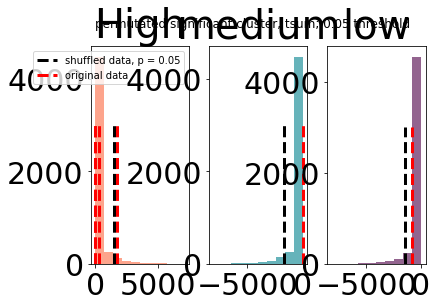

In [31]:
fs(30,10)
t1 = str(np.round(np.quantile(tCluster[0],0.95),2))
t2 = str(np.round(np.quantile(tCluster[1],0.05),2))
t3 = str(np.round(np.quantile(tCluster[2],0.05),2))


fig,ax = plt.subplots(ncols = 3)
ax[0].hist(tCluster[0],color = cList[0])
ax[0].vlines(x=np.quantile(tCluster[0],0.95),color = 'black',linewidth = 3,
           ymin = 0, ymax = 3000,linestyles='dashed',label = 'shuffled data, p = 0.05')
ax[0].vlines(x=allTH,color = 'red',linewidth = 3,
           ymin = 0, ymax = 3000,linestyles='dashed',label = 'original data')
ax[0].set_title('High',fontsize = 40)
ax[0].legend()
#ax[0].text(x = np.quantile(tCluster[0],0.95), y = 3000, s = t1)

ax[1].hist(tCluster[1],color = cList[4])
ax[1].vlines(x=np.quantile(tCluster[1],0.05),color = 'black',linewidth = 3,
           ymin = 0, ymax = 3000,linestyles='dashed')
ax[1].vlines(x=allTM,color = 'red',linewidth = 3,
           ymin = 0, ymax = 3000,linestyles='dashed')
ax[1].set_title('medium',fontsize = 40)
#ax[1].text(x = np.quantile(tCluster[1],0.05)-3000, y = 3000, s = t2)


ax[2].hist(tCluster[2],color = cList[2])
ax[2].vlines(x=np.quantile(tCluster[2],0.05),color = 'black',linewidth = 3,
           ymin = 0, ymax = 3000,linestyles='dashed')
ax[2].vlines(x=allTL,color = 'red',linewidth = 3,
           ymin = 0, ymax = 3000,linestyles='dashed')
ax[2].set_title('low',fontsize = 40)
#ax[2].text(x = np.quantile(tCluster[2],0.05)-3000, y = 3000, s = t3)
[ax[i].tick_params( labelsize=30) for i in range(3)]

plt.suptitle('permutated significant cluster, tsum; 0.05 threshold')

In [32]:
sum( tCluster[0] > allTH[0])/5000

0.0426

## across block reliability condition

In [33]:
#permutation with tCluster
perms = 5000
dataN = 2500
tCluster = np.zeros(shape = (3,perms))

condList = ["['high']","['medium']","['low']"]


eg = retroEpo[np.sum(retroEpo.iloc[:,:dataN].isnull(),axis = 1) ==0].reset_index(drop = True)
eg = eg.iloc[:,np.r_[np.arange(0,dataN),-2,-3,]]

In [34]:
#downsample to 12.5hz to be the same as the pupil lab 
binlen = 80

eg12 = eg.iloc[:,:2500].groupby(np.arange(len(eg.columns)-2)//binlen, axis=1).mean()
eg12['cue_blk_validity'] = eg['cue_blk_validity']
eg12['cued_item'] = eg['cued_item']

Text(0.5, 1.0, 'mean')

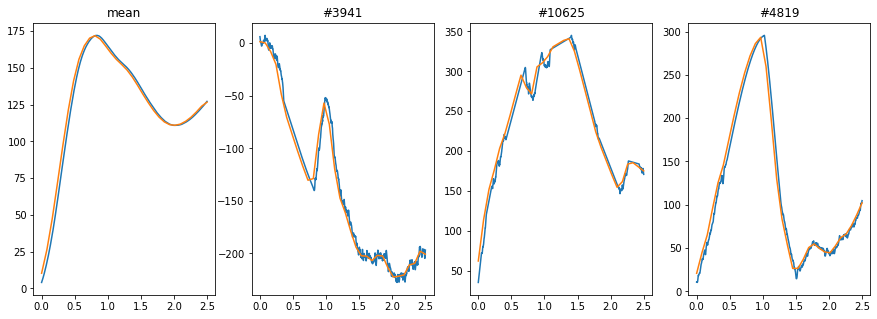

In [35]:
#checking to see if the data looks the same after downsampling
fs(15,5)
fig,ax = plt.subplots(ncols = 4)
ax[0].plot(np.linspace(0,2.5,2500),eg.iloc[:,:2500].mean())
ax[0].plot(np.linspace(0,2.5,32),eg12.iloc[:,:32].mean())

for i in range(1,4):
    randTrl = np.random.randint(13740)
    ax[i].plot(np.linspace(0,2.5,2500),eg.iloc[randTrl,:2500])
    ax[i].plot(np.linspace(0,2.5,32),eg12.iloc[randTrl,:32])
    ax[i].set_title('#'+str(randTrl))

ax[0].set_title('mean')


In [36]:
#need to change the column from int to str
eg12.columns = eg12.columns.astype(str)

#select the relevant conditions
eg12HL = eg12[eg12.cue_blk_validity != "['medium']"].reset_index(drop = True)
eg12HM = eg12[eg12.cue_blk_validity != "['low']"].reset_index(drop = True)
eg12ML = eg12[eg12.cue_blk_validity != "['high']"].reset_index(drop = True)

In [37]:
k = [pg.anova(data = eg12HL, dv = i,
              between = ['cued_item','cue_blk_validity'])[['F',
                                                           'p-unc']].iloc[2,:] for i in eg12HL.columns[:32].values]
q = [pg.anova(data = eg12HM, dv = i,
              between = ['cued_item','cue_blk_validity'])[['F',
                                                           'p-unc']].iloc[2,:] for i in eg12HM.columns[:32].values]
j = [pg.anova(data = eg12ML, dv = i,
              between = ['cued_item','cue_blk_validity'])[['F',
                                                           'p-unc']].iloc[2,:] for i in eg12ML.columns[:32].values]

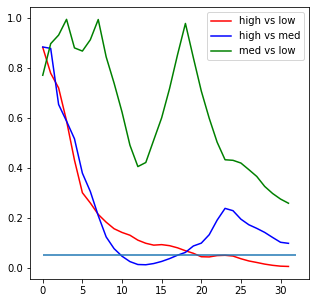

In [38]:
fs(5,5)
plt.plot(np.array(k)[:,1],'r',label = 'high vs low')
plt.plot(np.array(q)[:,1],'b',label = 'high vs med')
plt.plot(np.array(j)[:,1],'g',label = 'med vs low') # no need to compare med vs low since there's no p value cluster

plt.legend()
plt.hlines(0.05,0,32,)

### high vs medium

In [39]:
"""
perms = 5000
fCluster = np.zeros(perms) # permutation iteration x data x f and p 

for n in range(perms):
        print(n)
        # shuffle block label
        eg12HM['randLabel'] = np.random.permutation(eg12HM.cue_blk_validity.values)

        # for each time point, 2 way anova with blk reliability and cued item as dv, and the data as dv
        # get the f score for the interaction effect
        fpThis = np.array([pg.anova(data = eg12HM, dv = i,
              between = ['cued_item','randLabel'])[['F','p-unc']].iloc[2,:] for i in eg12HM.columns[:32].values])
        fArr = fpThis[:,0]

        # find the clusters that exceed p value threshold
        consGroups = consecutive(np.where(fpThis[:,1] < 0.05)[0], stepsize=1,
                        findSame = False)
        
        # find the cluster with the largest length,then find its corresponding t values, sum it up
                #note: if no cluster is found, this will return 0
        fCluster[n] =  np.round(fArr[consGroups[np.argmax(np.array([len(t) for t in consGroups]))]].sum(),3)

"""

"\nperms = 5000\nfCluster = np.zeros(perms) # permutation iteration x data x f and p \n\nfor n in range(perms):\n        print(n)\n        # shuffle block label\n        eg12HM['randLabel'] = np.random.permutation(eg12HM.cue_blk_validity.values)\n\n        # for each time point, 2 way anova with blk reliability and cued item as dv, and the data as dv\n        # get the f score for the interaction effect\n        fpThis = np.array([pg.anova(data = eg12HM, dv = i,\n              between = ['cued_item','randLabel'])[['F','p-unc']].iloc[2,:] for i in eg12HM.columns[:32].values])\n        fArr = fpThis[:,0]\n\n        # find the clusters that exceed p value threshold\n        consGroups = consecutive(np.where(fpThis[:,1] < 0.05)[0], stepsize=1,\n                        findSame = False)\n        \n        # find the cluster with the largest length,then find its corresponding t values, sum it up\n                #note: if no cluster is found, this will return 0\n        fCluster[n] =  np.rou

In [40]:
fCluster = pd.read_csv('data4Paper/data4PupResults/permutationResults/blkItemInteractionClusterPermutation5000_el12hzHM.csv').iloc[:,1:].T.values

(0.0, 300.0)

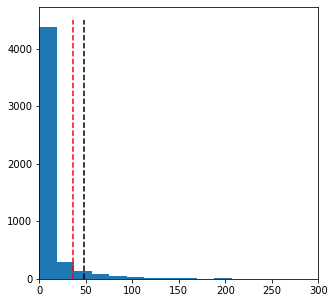

In [41]:
fs(5,5)

realF = np.array(q)[:,0]
realP = np.array(q)[:,1]

consGroups = consecutive(np.where(realP <= 0.05)[0], stepsize=1,
                        findSame = False)
fsum = [realF[i].sum() for i in consGroups]

plt.hist(fCluster[0],bins = 20)
plt.vlines([fsum],0,4500,linestyles = 'dashed',color ='r')
plt.vlines(np.percentile(fCluster,95),0,4500,linestyles = 'dashed',color ='black')
plt.xlim(0,300)

In [42]:
print('pvalue:',sum(fCluster[0] > fsum[0])/5000)
print('sig period:',consGroups[0]*80)

pvalue: 0.0728
sig period: [ 800  880  960 1040 1120 1200 1280]


### for high vs low

In [43]:
# for each iteraction
"""
perms = 5000
fCluster = np.zeros(perms) # permutation iteration x data x f and p 

for n in range(perms):
        print(n)
        # shuffle block label
        eg12HL['randLabel'] = np.random.permutation(eg12HL.cue_blk_validity.values)

        # for each time point, 2 way anova with blk reliability and cued item as dv, and the data as dv
        # get the f score for the interaction effect
        fpThis = np.array([pg.anova(data = eg12HL, dv = i,
              between = ['cued_item','randLabel'])[['F','p-unc']].iloc[2,:] for i in eg12HL.columns[:32].values])
        fArr = fpThis[:,0]

        # find the clusters that exceed p value threshold
        consGroups = consecutive(np.where(fpThis[:,1] < 0.05)[0], stepsize=1,
                        findSame = False)
        
        # find the cluster with the largest length,then find its corresponding t values, sum it up
                #note: if no cluster is found, this will return 0
        fCluster[n] =  np.round(fArr[consGroups[np.argmax(np.array([len(t) for t in consGroups]))]].sum(),3)

# for the real data array, ran the anova test, get the f score clusters sum.
"""

"\nperms = 5000\nfCluster = np.zeros(perms) # permutation iteration x data x f and p \n\nfor n in range(perms):\n        print(n)\n        # shuffle block label\n        eg12HL['randLabel'] = np.random.permutation(eg12HL.cue_blk_validity.values)\n\n        # for each time point, 2 way anova with blk reliability and cued item as dv, and the data as dv\n        # get the f score for the interaction effect\n        fpThis = np.array([pg.anova(data = eg12HL, dv = i,\n              between = ['cued_item','randLabel'])[['F','p-unc']].iloc[2,:] for i in eg12HL.columns[:32].values])\n        fArr = fpThis[:,0]\n\n        # find the clusters that exceed p value threshold\n        consGroups = consecutive(np.where(fpThis[:,1] < 0.05)[0], stepsize=1,\n                        findSame = False)\n        \n        # find the cluster with the largest length,then find its corresponding t values, sum it up\n                #note: if no cluster is found, this will return 0\n        fCluster[n] =  np.rou

In [44]:
fCluster = pd.read_csv('data4Paper/data4PupResults/permutationResults/blkItemInteractionClusterPermutation5000_el12hzHL.csv').iloc[:,1:].T.values

(0.0, 300.0)

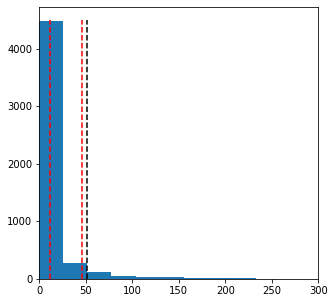

In [45]:
fs(5,5)

realF = np.array(k)[:,0]
realP = np.array(k)[:,1]

consGroups = consecutive(np.where(realP <= 0.05)[0], stepsize=1,
                        findSame = False)
fsum = [realF[i].sum() for i in consGroups]

plt.hist(fCluster[0],bins = 20)
plt.vlines([fsum],0,4500,linestyles = 'dashed',color ='r')
plt.vlines(np.percentile(fCluster,95),0,4500,linestyles = 'dashed',color ='black')
plt.xlim(0,300)

In [46]:
print('pvalue:',[sum(fCluster[0] > fsum[i])/5000 for i in range(2)])
print('sig period:',[consGroups[i]*80 for i in range(2)])

pvalue: [0.167, 0.0586]
sig period: [array([1600, 1680, 1760], dtype=int64), array([1920, 2000, 2080, 2160, 2240, 2320, 2400, 2480], dtype=int64)]


In [47]:
#permutation with tCluster
perms = 5000
dataN = 2500
tCluster = np.zeros(shape = (3,perms))

condList = ["['high']","['medium']","['low']"]


eg = retroEpo[np.sum(retroEpo.iloc[:,:dataN].isnull(),axis = 1) ==0].reset_index(drop = True)
eg = eg.iloc[:,np.r_[np.arange(0,dataN),-2,-3,-4]]

In [48]:
#downsample to 12.5hz to be the same as the pupil lab 
binlen = 80

In [49]:
eg12 = eg.iloc[:,:2500].groupby(np.arange(len(eg.columns)-3)//binlen, axis=1).mean()
eg12['cue_blk_validity'] = eg['cue_blk_validity']
eg12['cued_item'] = eg['cued_item']
eg12['identifier'] = eg['identifier']

Text(0.5, 1.0, 'mean')

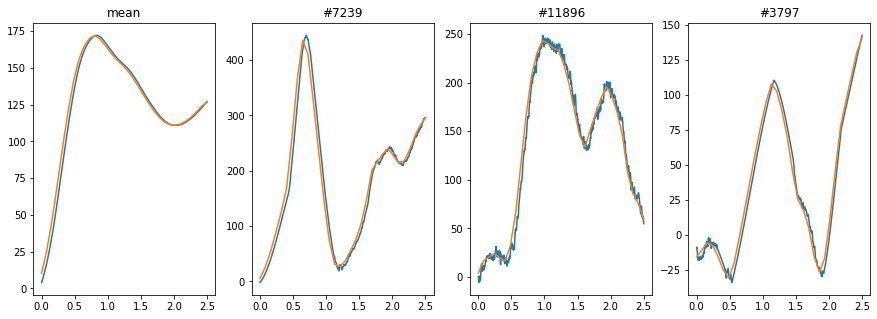

In [50]:
fs(15,5)
fig,ax = plt.subplots(ncols = 4)
ax[0].plot(np.linspace(0,2.5,2500),eg.iloc[:,:2500].mean())
ax[0].plot(np.linspace(0,2.5,32),eg12.iloc[:,:32].mean())

for i in range(1,4):
    randTrl = np.random.randint(13740)
    ax[i].plot(np.linspace(0,2.5,2500),eg.iloc[randTrl,:2500])
    ax[i].plot(np.linspace(0,2.5,32),eg12.iloc[randTrl,:32])
    ax[i].set_title('#'+str(randTrl))

ax[0].set_title('mean')


# original vs. downsampled

In [60]:
qq = retroEpo.groupby(['cued_item']).mean().iloc[:,:2500]
pp = eg12.groupby(['cued_item']).mean().iloc[:,:32]

In [61]:
fs(24,10)

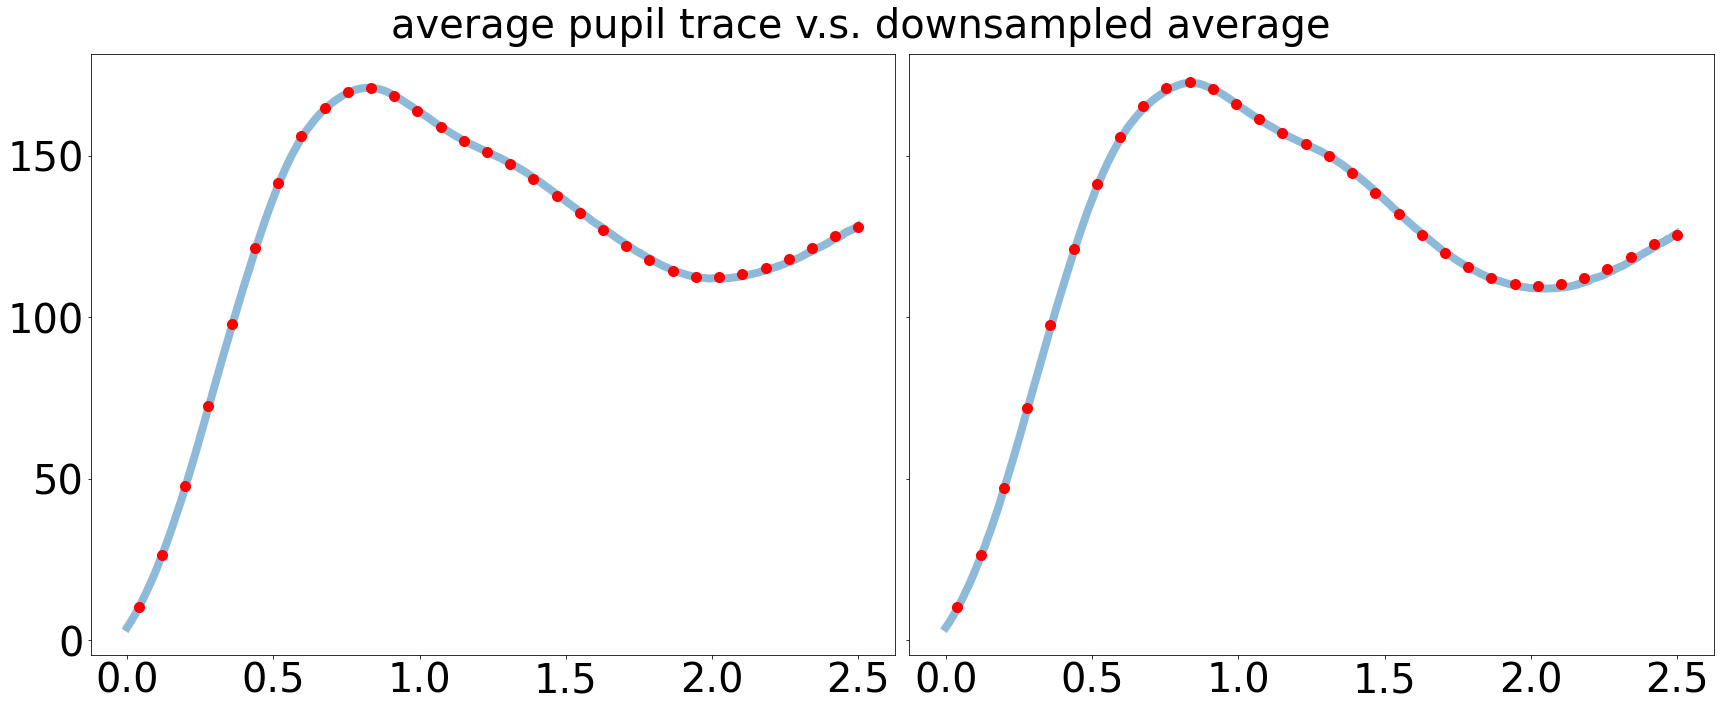

In [62]:
fig,ax = plt.subplots(ncols = 2,sharex = True,sharey = True)

x = np.linspace(0,2.5,2500)

[ax[i].plot(x,qq.iloc[i,:],linewidth = 8,alpha = 0.5) for i in range(2)]
[ax[i].scatter(np.linspace(0.04,2.5,32),pp.iloc[i,:],c = 'r',s = 100,zorder = 10)for i in range(2)];

fig.suptitle('average pupil trace v.s. downsampled average',fontsize = 40)
ax[0].yaxis.set_major_locator(ticker.MultipleLocator(50))

[ax[i].tick_params(labelsize = 40) for i in range(2)]


fig.tight_layout()


In [63]:
qq = retroEpo.groupby(['cue_blk_validity','cued_item',]).mean().iloc[:,:2500]
pp = eg12.groupby(['cue_blk_validity','cued_item',]).mean().iloc[:,:32]

In [64]:
12.5*2.5

31.25

In [65]:
fs(24,6)

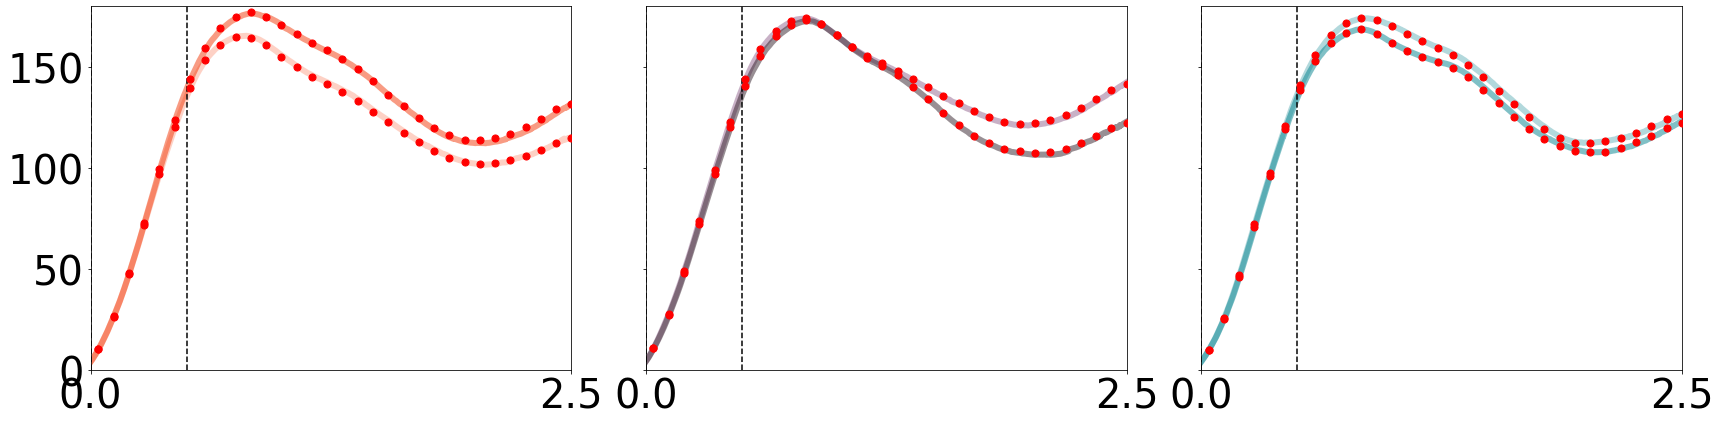

In [66]:
fig,ax = plt.subplots(ncols =3,sharex = True,sharey = True)
[ax[i//2].plot(x,qq.iloc[i,:],linewidth = 6,alpha = 0.5,c = cList[i]) for i in range(6)];
[ax[i//2].scatter(np.linspace(0.04,2.5,32), pp.iloc[i,:],c = 'red',s = 50,zorder = 10)for i in range(6)];
ax[0].yaxis.set_major_locator(ticker.MultipleLocator(50))
ax[0].xaxis.set_major_locator(ticker.MultipleLocator(2.5))

[ax[i].vlines([0,0.5],0,180,linestyles = 'dashed',colors = 'black') for i in range(3)]
[ax[i].tick_params(labelsize = 40) for i in range(3)]

[ax[i].set_xlim(0,2.5) for i in range(3)]
[ax[i].set_ylim(0,180) for i in range(3)]

fig.tight_layout()

In [67]:
randTrl = np.random.choice(retroEpo.identifier,6)
aa = retroEpo[retroEpo.identifier.isin(randTrl)]
bb = eg12[eg12.identifier.isin(randTrl)].iloc[:,:32]

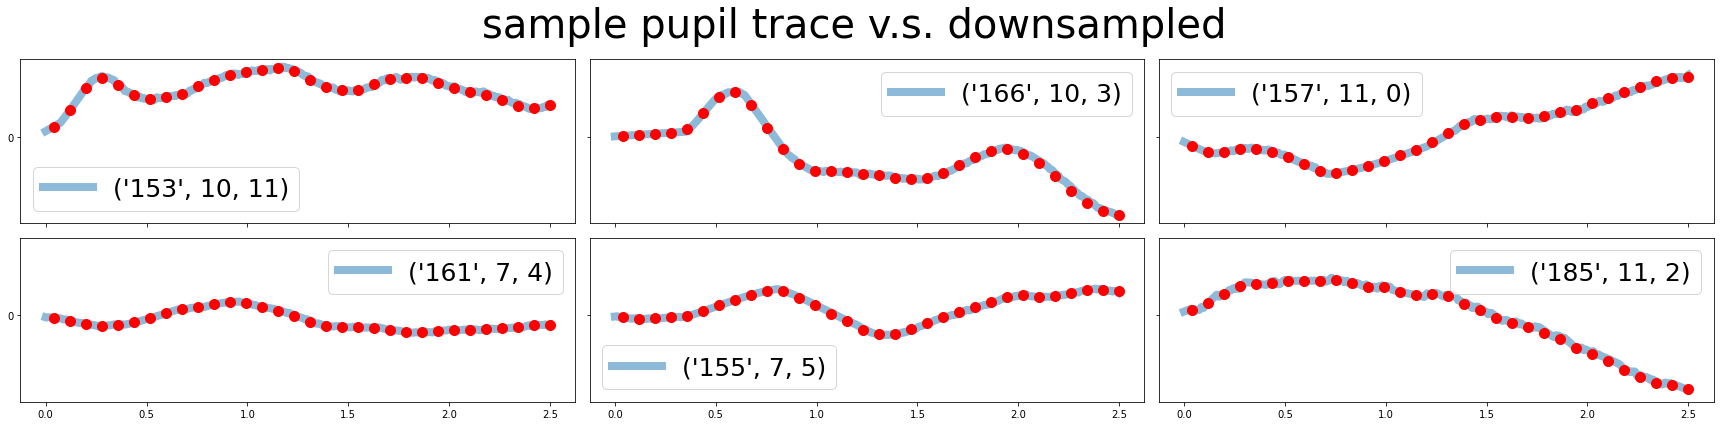

In [68]:
fig,ax = plt.subplots(ncols = 3,nrows = 2,sharex = True,sharey = True)

x = np.linspace(0,2.5,2500)

[ax[i%2][i%3].plot(x,aa.iloc[i,:2500],linewidth = 8,alpha = 0.5,
                   label = aa.identifier.values[i]) for i in range(6)]
[ax[i%2][i%3].scatter(np.linspace(0.04,2.5,32),bb.iloc[i,:],c = 'r',s = 100,zorder = 10)for i in range(6)];

fig.suptitle('sample pupil trace v.s. downsampled ',fontsize = 40)
ax[0][0].yaxis.set_major_locator(ticker.MultipleLocator(500))

#[ax[i].tick_params(labelsize = 40) for i in range(2)]

[ax[i%2][i%3].legend(prop = {'size':25}) for i in range(6)]
fig.tight_layout()


# pupil plot

### pupil grand

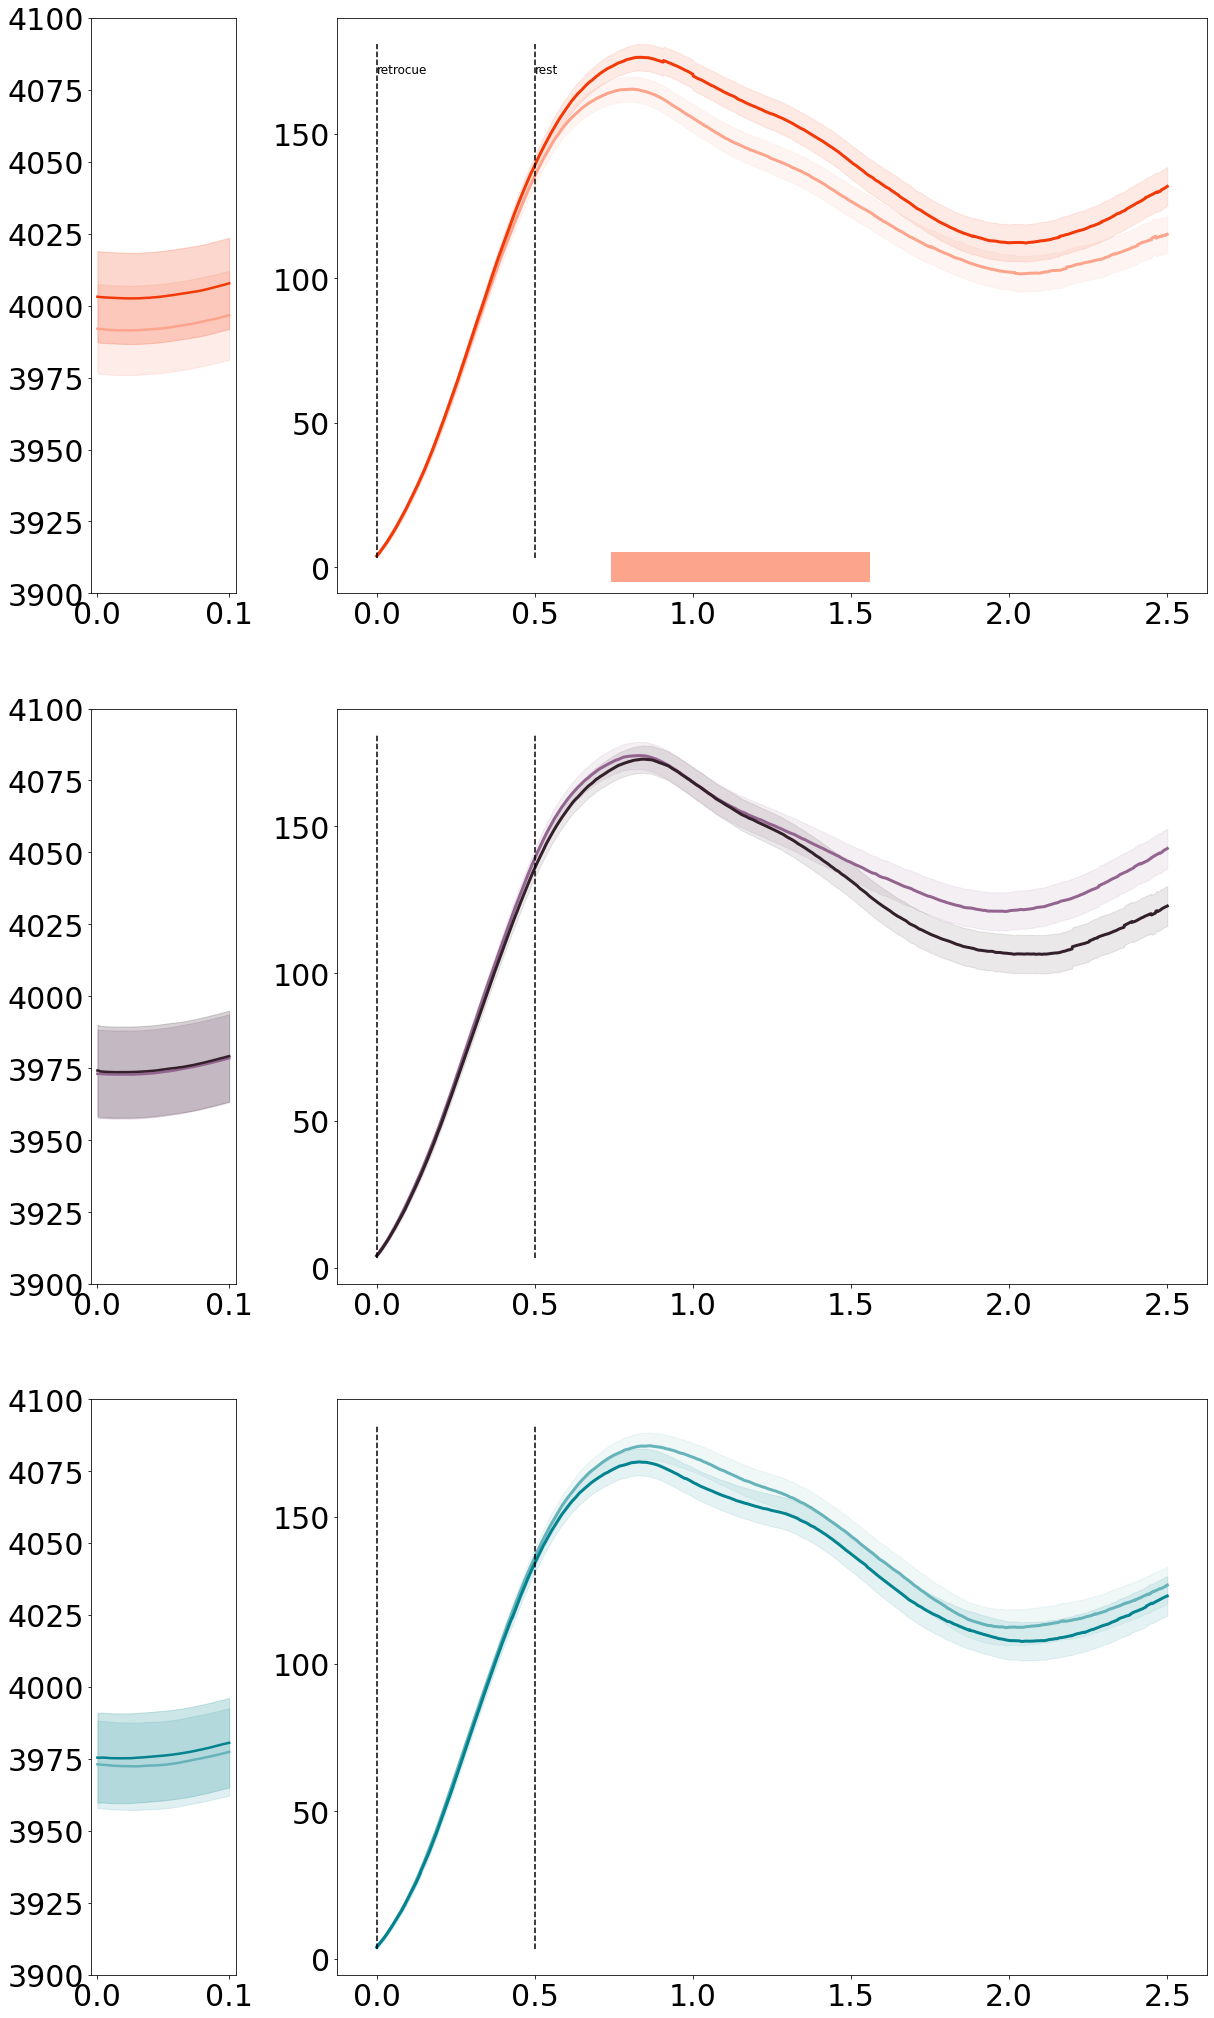

In [46]:
#grand - retro
highSig = consecutive(np.where(trueHP <  0.05)[0], stepsize=1,
               findSame = False) #get the sig period
#draw
normmean, norm_sterr = pupilPlot(normPup = retroEpo.iloc[:,np.r_[np.arange(0,2500),-4,-3,-2]],blPup = retroEpoBL.iloc[:,:-1],
          eventt = 2.5,levels=['cue_blk_validity', 'cued_item'],
          blt  = 0.1,cList = cList,pltRatio = [0.5,3],blHeight = [3900,4100],
          eventBoundary = epoch_array[2:-2]-0.75,
          eventName = epoch_name[2:-2],figW = 20,figH = 12,tickSize=30,
          tightPlot=False,
          sigPeriod = [highSig[0][0],highSig[0][-1]])



## grand diff

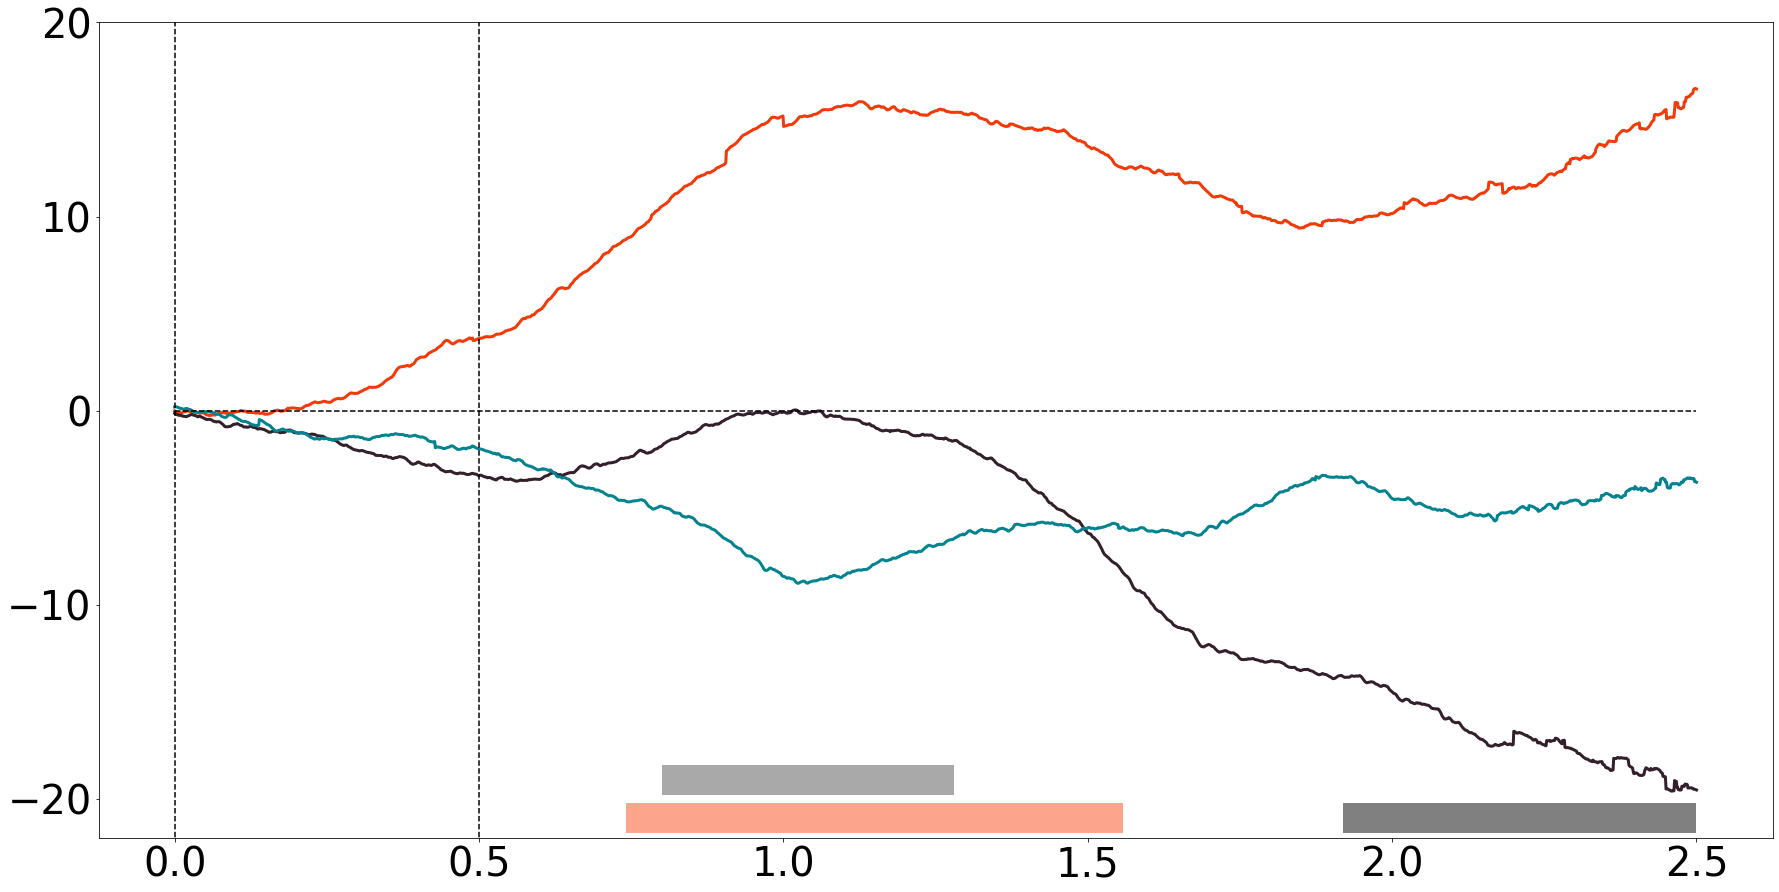

In [47]:
fs(30,15)
cDict = {"['high']":'#f23908',"['medium']":'#03838f',"['low']":'#33202a'}
fig,ax= plt.subplots(nrows= 1)
x = np.linspace(0,2.5,normmean.shape[1])

for f in normmean.index.get_level_values('cue_blk_validity').unique():
    diff = normmean.loc[f,'dar'] - normmean.loc[f,'bri']
    plt.plot(x,diff,color = cDict[f],label = f,linewidth = 3)

plt.vlines(epoch_array[2:-2]-0.75,-30,30,
           linestyles = 'dashed',colors= 'black')
plt.hlines(0,0,epoch_array[-2]-0.75,linestyles = 'dashed',colors= 'black')
plt.hlines(-21,x[highSig[0][0]],x[highSig[0][-1]],colors = cList[0],
           linewidth = 30)
plt.hlines(-21,1.92,2.5,colors = 'grey',
           linewidth = 30)
plt.hlines(-19,0.8,1.28,colors = 'darkgray',
           linewidth = 30)


plt.ylim(-22,20)
#plt.title('Pupillary memory effect',size = 40)
#plt.legend(prop={'size': 20},loc=3,)
ax.yaxis.set_major_locator(ticker.MultipleLocator(10))

plt.tick_params(labelsize = 40)
plt.show()

# pupil vviq

## vviq dist

In [49]:
vviq = pd.read_csv('data4Paper/data4PupResults/vviq.csv')[['id','vviq']].reset_index(drop = True).iloc[2:,:].reset_index(drop = True).astype(float)

In [50]:
vviq.shape

(49, 2)

In [51]:
vviq.describe()

,id,vviq
count,49.000000,49.000000
mean,172.530612,54.408163
std,14.726821,12.392737
min,148.000000,16.000000
25%,160.000000,47.000000
50%,173.000000,56.000000
75%,185.000000,62.000000
max,197.000000,76.000000


(0.0, 80.0)

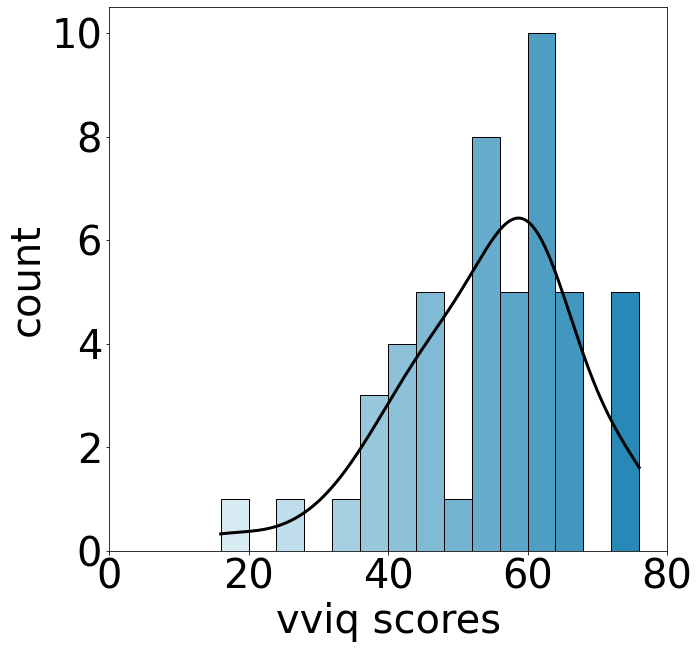

In [52]:
fs(10,10)

#first color is light blue, last is dark blue
colors = [ '#d8ebf2','#2889b7',] 
binNum = 15

#draw the histplot
ax = sns.histplot(x = 'vviq', kde = True, data = vviq,
    line_kws=dict(linewidth=3,color = 'black'),linewidth = 1,bins = binNum,color = 'black')

#create the colored bins
cm = LinearSegmentedColormap.from_list(
        "Custom", colors, N=binNum)
[p.set(color = cm(n),linewidth = 1,edgecolor = 'black') for n,p in enumerate(ax.patches)]


#plt.title('vviq scores histogram',size = 40)
plt.xlabel('vviq scores',size = 40)
plt.ylabel('count',size = 40)
plt.tick_params( labelsize=40)
plt.xlim(0,80)

In [53]:
#select the top/med/bottom 1/3 imagers
vviqCutOff = np.percentile(vviq.vviq,[33,67])
vviqhigh = vviq[vviq.vviq >= vviqCutOff[1]].id.astype(float)
vviqlow = vviq[vviq.vviq <= vviqCutOff[0]].id.astype(float)
vviqmed = vviq[(vviq.vviq > vviqCutOff[0])&(vviq.vviq < vviqCutOff[1])].id.astype(float)
len(vviqlow),len(vviqmed),len(vviqhigh)

(16, 16, 17)

## vviq 1/3 split, pupil

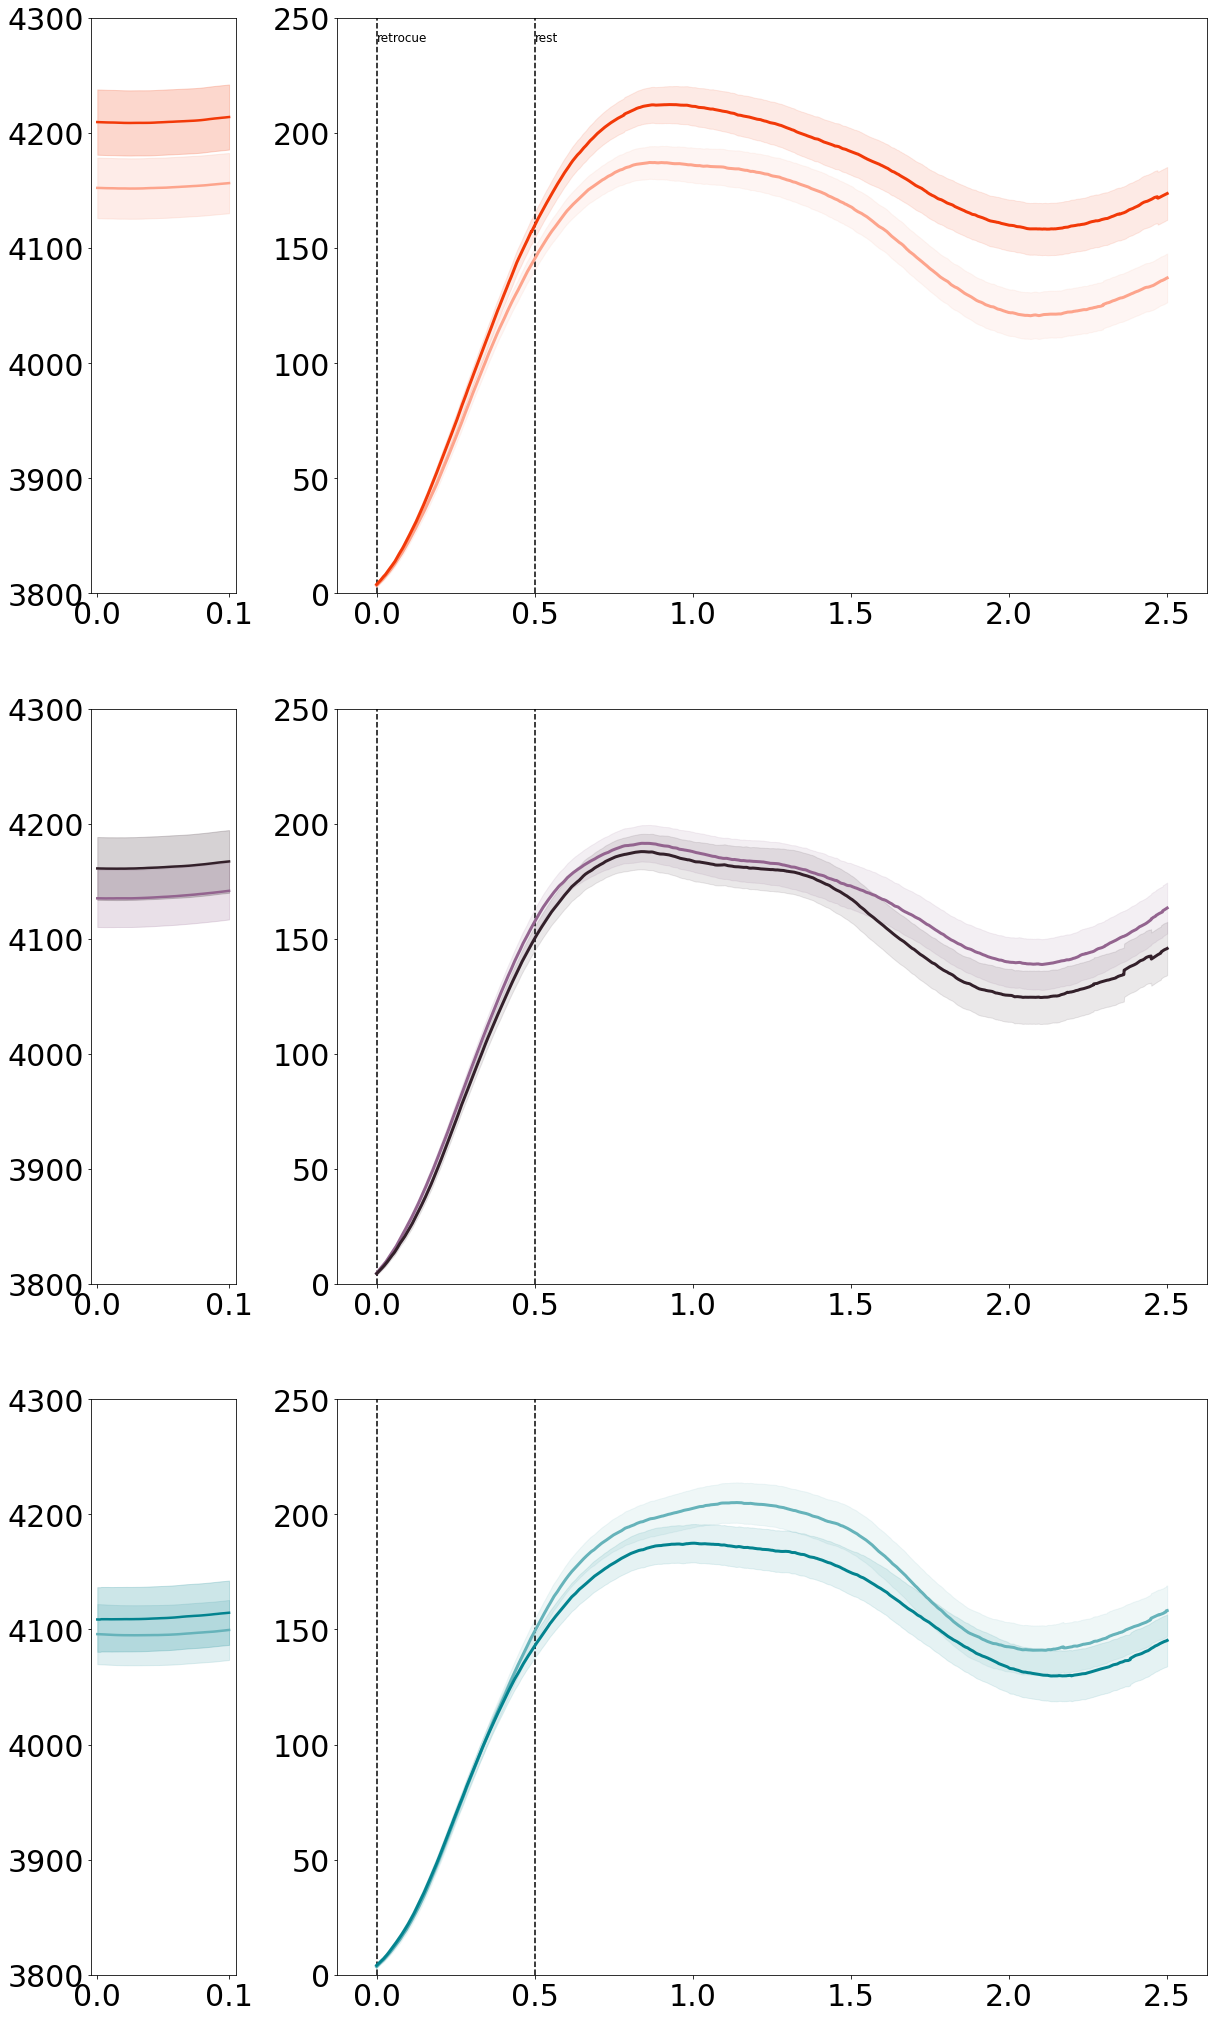

In [88]:
#grand - retro; high vviq subj
normmean, norm_sterr = pupilPlot(normPup = retroEpo[retroEpo.subj.isin(vviqhigh)].reset_index(drop = True),
                                 blPup = retroEpoBL[retroEpoBL.subj.isin(vviqhigh)].iloc[:,:-1].reset_index(drop = True),
          eventt = 2.5,levels=['cue_blk_validity', 'cued_item'],
          blt  = 0.1,cList = cList,pltRatio = [0.5,3],blHeight = [3800,4300],mainFigHeight = [0,250],
          eventBoundary = epoch_array[2:-2]-0.75,
          eventName = epoch_name[2:-2],figW = 20,figH = 12,tickSize=30,
          tightPlot=False)

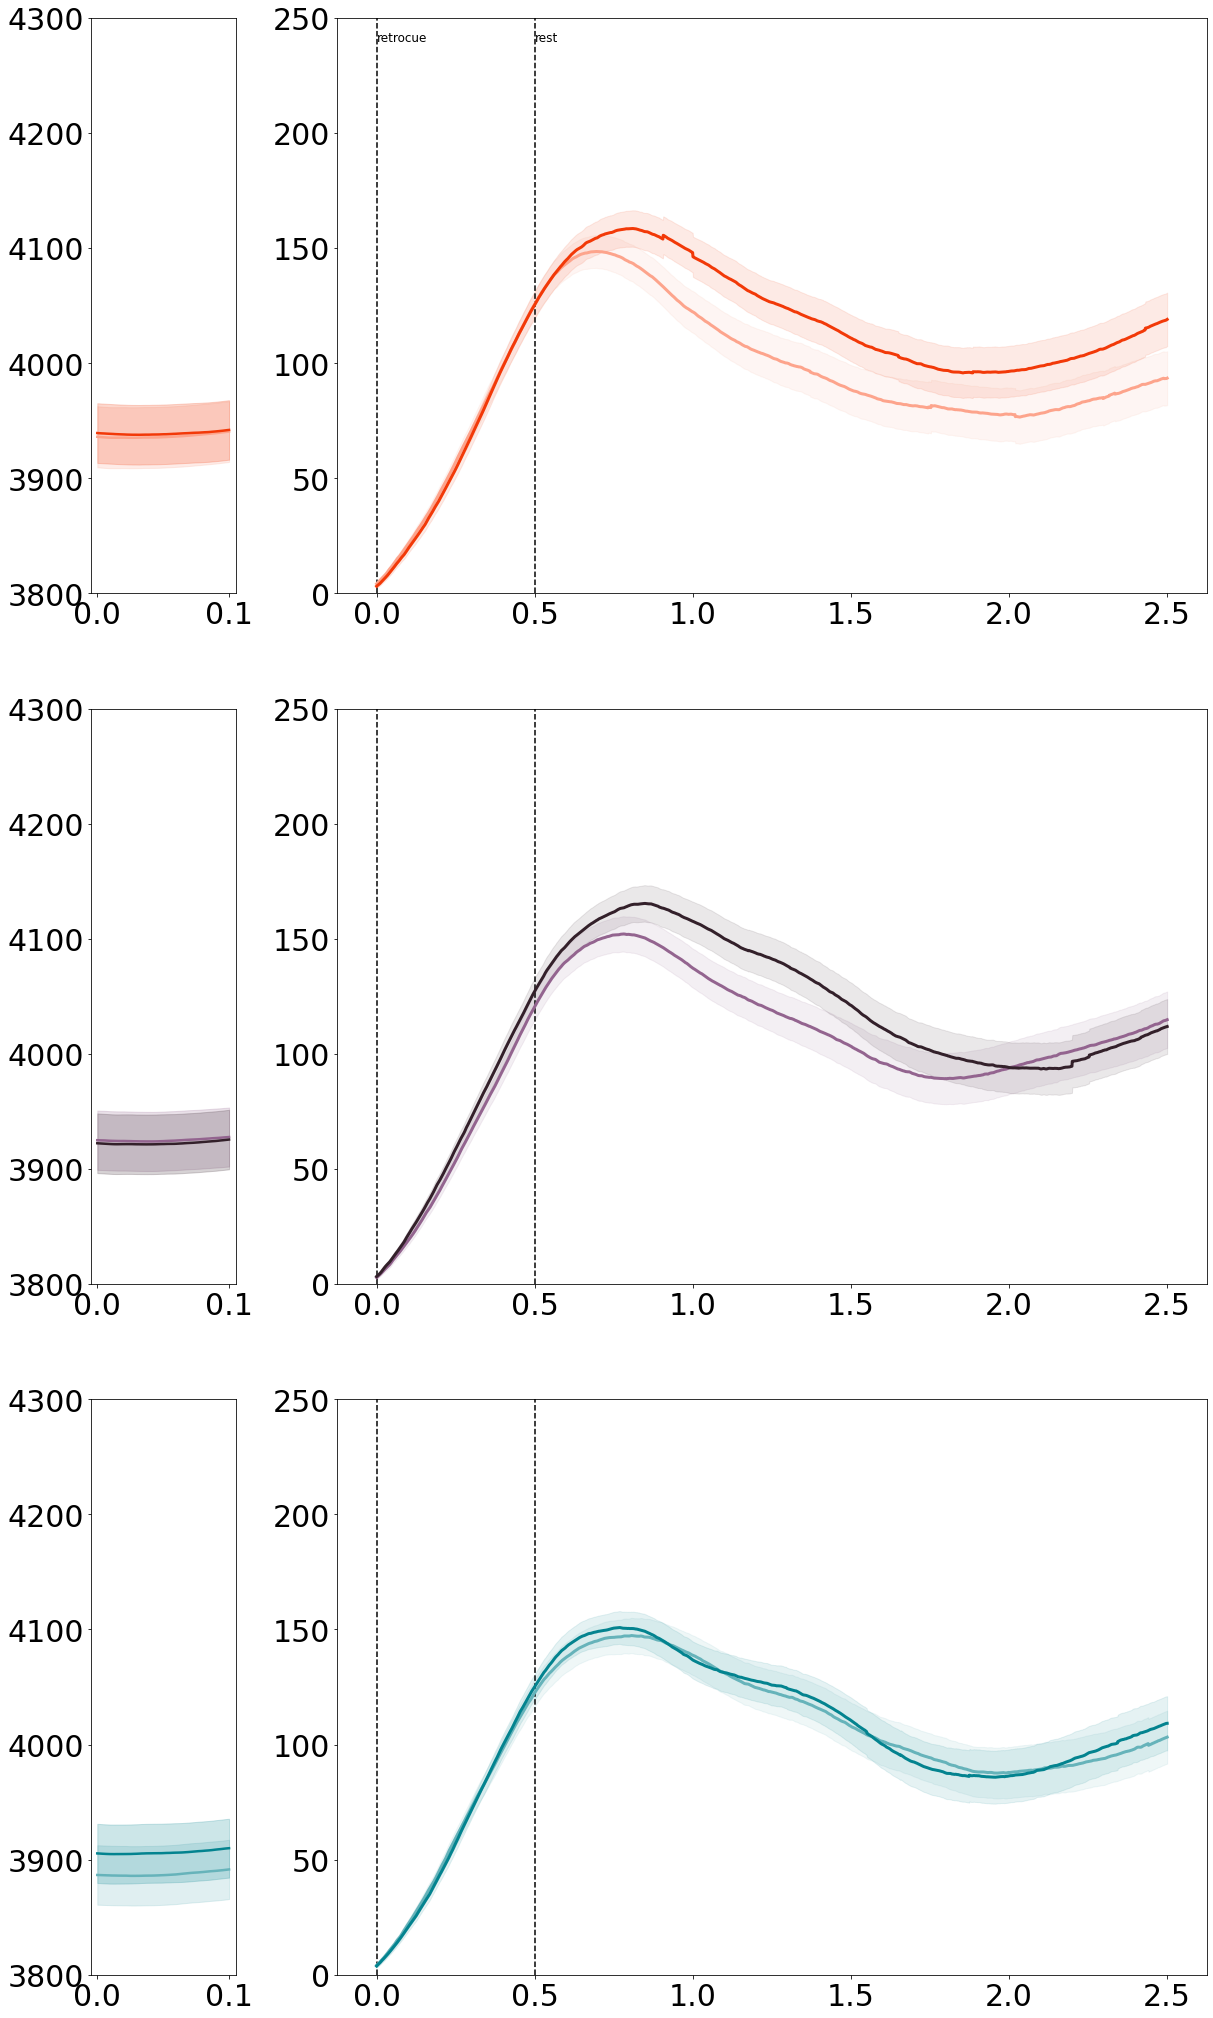

In [89]:
#grand - retro
normmean, norm_sterr = pupilPlot(normPup = retroEpo[retroEpo.subj.isin(vviqmed)].reset_index(drop = True),
                                 blPup = retroEpoBL[retroEpoBL.subj.isin(vviqmed)].iloc[:,:-1].reset_index(drop = True),
          eventt = 2.5,levels=['cue_blk_validity', 'cued_item'],
          blt  = 0.1,cList = cList,pltRatio = [0.5,3],blHeight = [3800,4300],mainFigHeight = [0,250],
          eventBoundary = epoch_array[2:-2]-0.75,
          eventName = epoch_name[2:-2],figW = 20,figH = 12,tickSize=30,
          tightPlot=False)

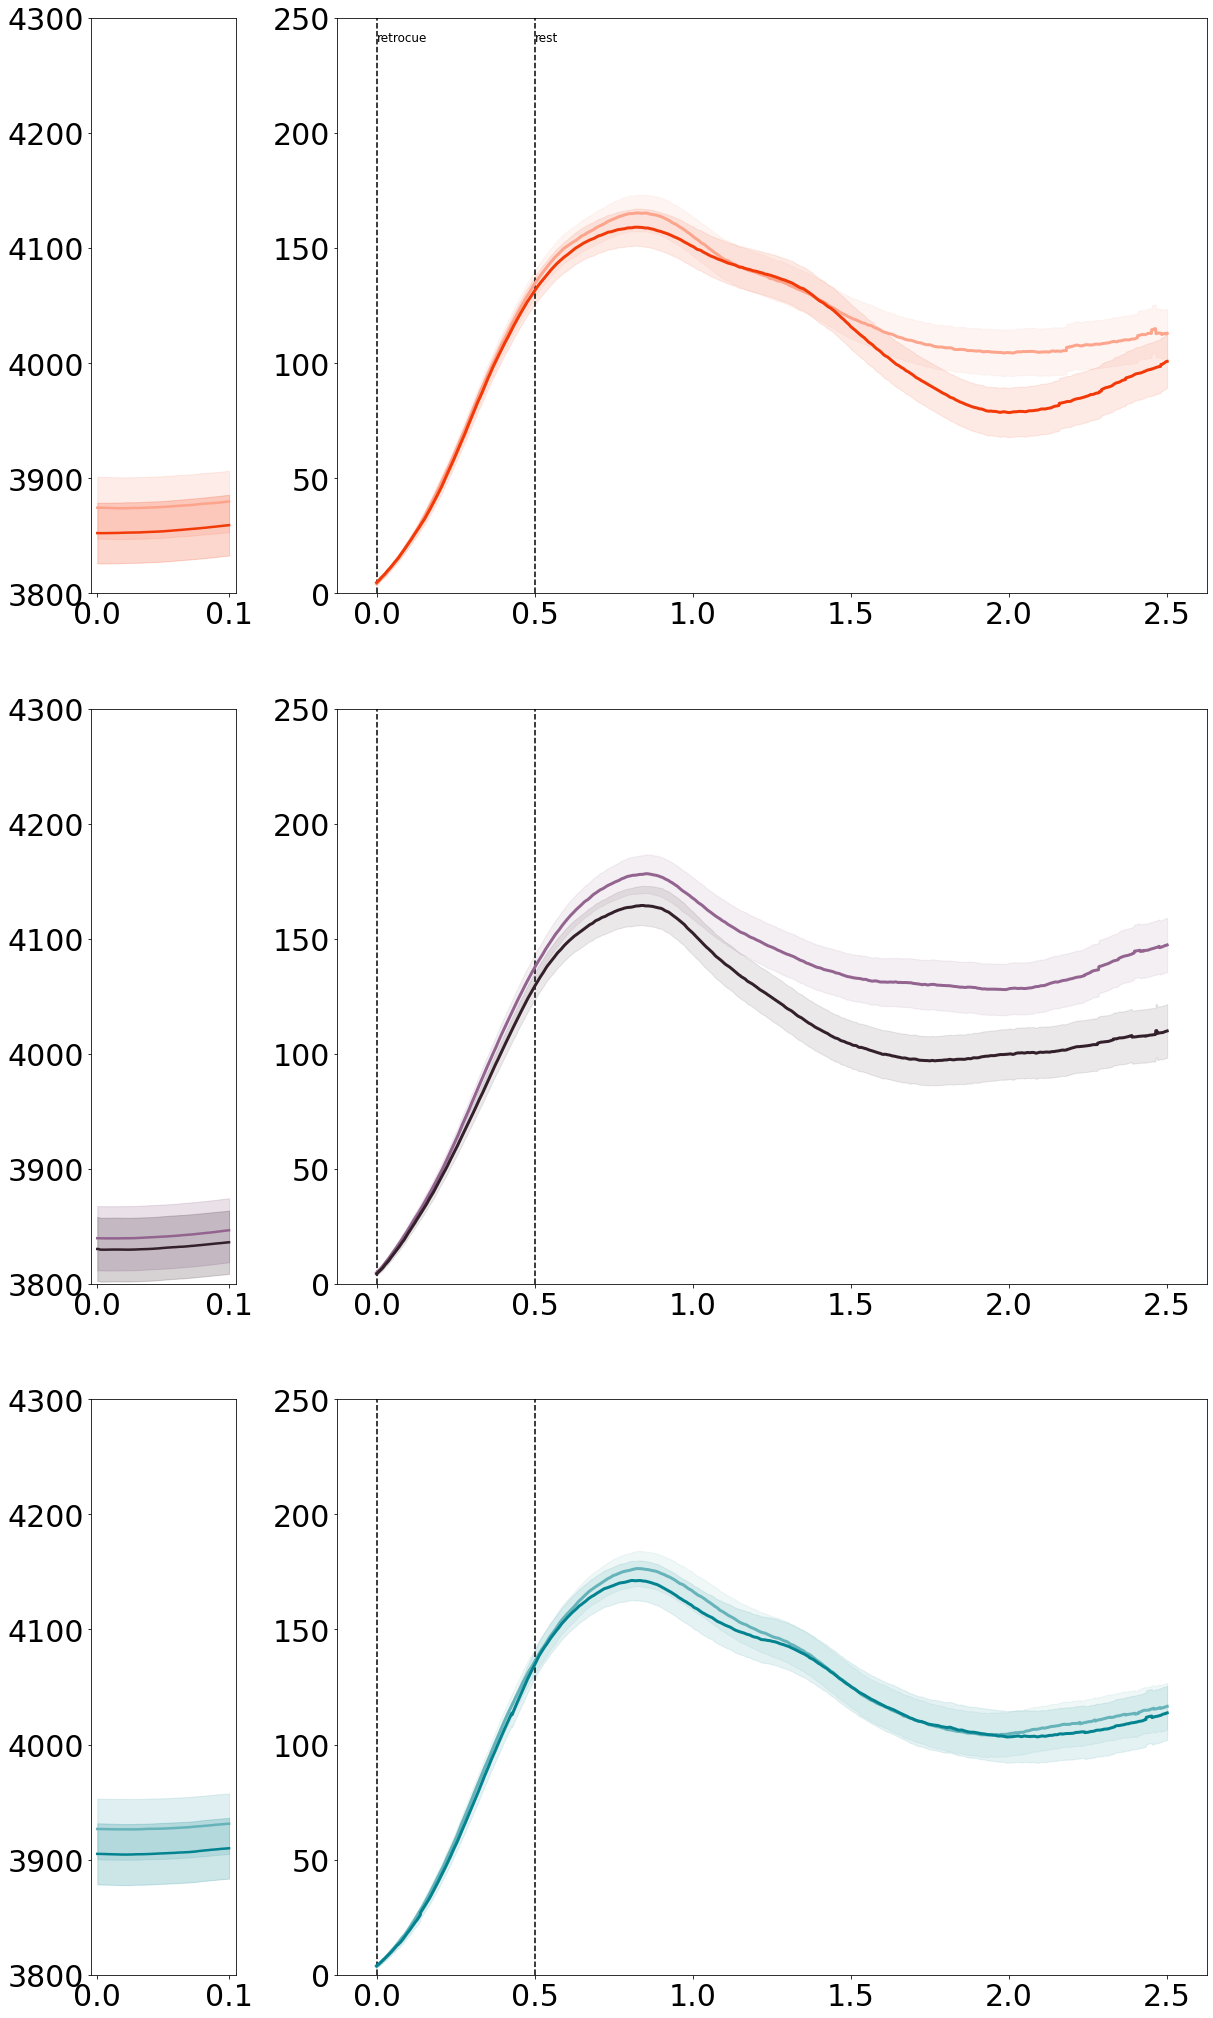

In [90]:
#grand - retro
normmean, norm_sterr = pupilPlot(normPup = retroEpo[retroEpo.subj.isin(vviqlow)].reset_index(drop = True),
                                 blPup = retroEpoBL[retroEpoBL.subj.isin(vviqlow)].iloc[:,:-1].reset_index(drop = True),
          eventt = 2.5,levels=['cue_blk_validity', 'cued_item'],
          blt  = 0.1,cList = cList,pltRatio = [0.5,3],blHeight = [3800,4300],mainFigHeight = [0,250],
          eventBoundary = epoch_array[2:-2]-0.75,
          eventName = epoch_name[2:-2],figW = 20,figH = 12,tickSize=30,
          tightPlot=False)

## vviq continuous

In [91]:
#select the delay period
data1 = int(0.5*1000)
data2 = int(2.5*1000)

In [92]:
#create a df with the mean pupil for each subj, for  trl conditions & block
vviqPupMean = retroEpo.groupby(['subj','cue_blk_validity','cued_item']).mean().iloc[:,data1:data2].mean(axis = 1).reset_index()
vviqPupMean.rename(columns = {0:'meanPup_delay'},inplace = True)
vviqPupMean = vviqPupMean.merge(vviq,left_on = 'subj',right_on = 'id').drop(columns = 'id')

#calculate the pupil memory signal
tempDiff_blk = pd.concat([vviqPupMean.loc[::2,['subj','cue_blk_validity','vviq']].reset_index(drop = True),
    vviqPupMean.loc[1::2,'meanPup_delay'].reset_index(drop = True) - vviqPupMean.loc[::2,'meanPup_delay'].reset_index(drop = True)],axis = 1)

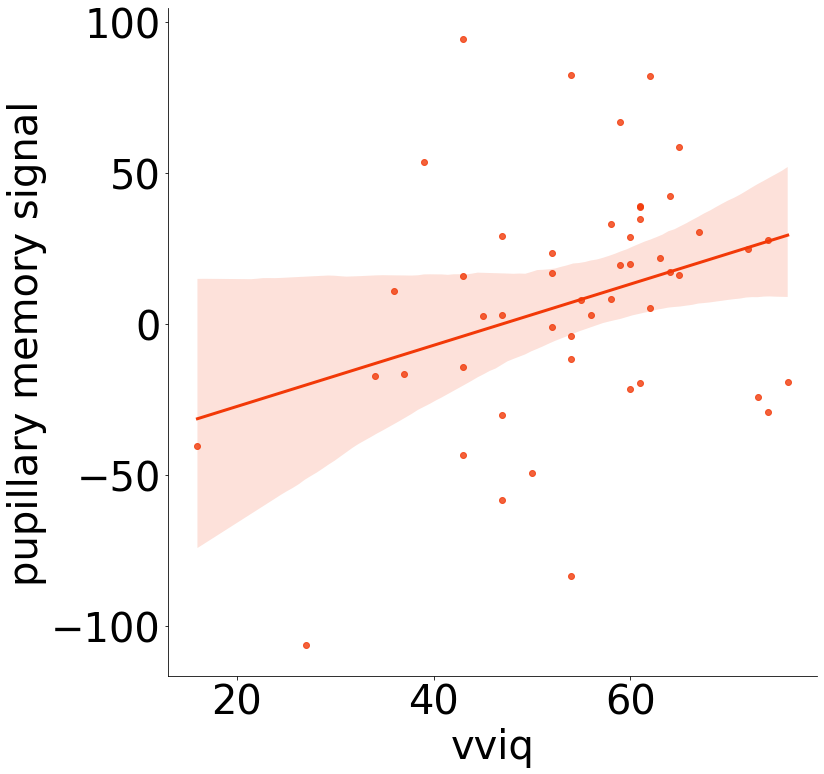

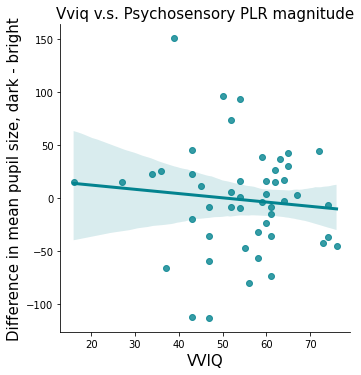

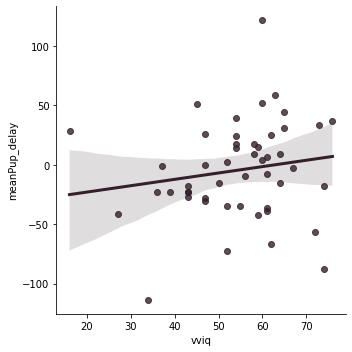

In [94]:
#for plotting, I set the label of the block column
tempDiff_blk.rename(columns = {'cue_blk_validity':'blockReliabilty'},inplace = True)

sns.lmplot(x = 'vviq',y = 'meanPup_delay',
                scatter_kws = dict(color = cList[1]),line_kws = dict(linewidth=3,color = cList[1]),
                data = tempDiff_blk[tempDiff_blk.blockReliabilty == "['high']"],height = 10,aspect = 1)
plt.xlabel('vviq',fontsize = 40)
plt.ylabel('pupillary memory signal',fontsize = 40)
plt.tick_params(labelsize = 40)

sns.lmplot(x = 'vviq',y = 'meanPup_delay',
                scatter_kws = dict(color = cList[5]),line_kws = dict(linewidth=3,color = cList[5]),
                data = tempDiff_blk[tempDiff_blk.blockReliabilty == "['medium']"],)


plt.xlabel('VVIQ',size = 15)
plt.ylabel('Difference in mean pupil size, dark - bright',size = 15)
plt.title('Vviq v.s. Psychosensory PLR magnitude',size = 15)
sns.lmplot(x = 'vviq',y = 'meanPup_delay',
                scatter_kws = dict(color = cList[3]),line_kws = dict(linewidth=3,color = cList[3]),
                data = tempDiff_blk[tempDiff_blk.blockReliabilty == "['low']"],)




#fig.tight_layout()

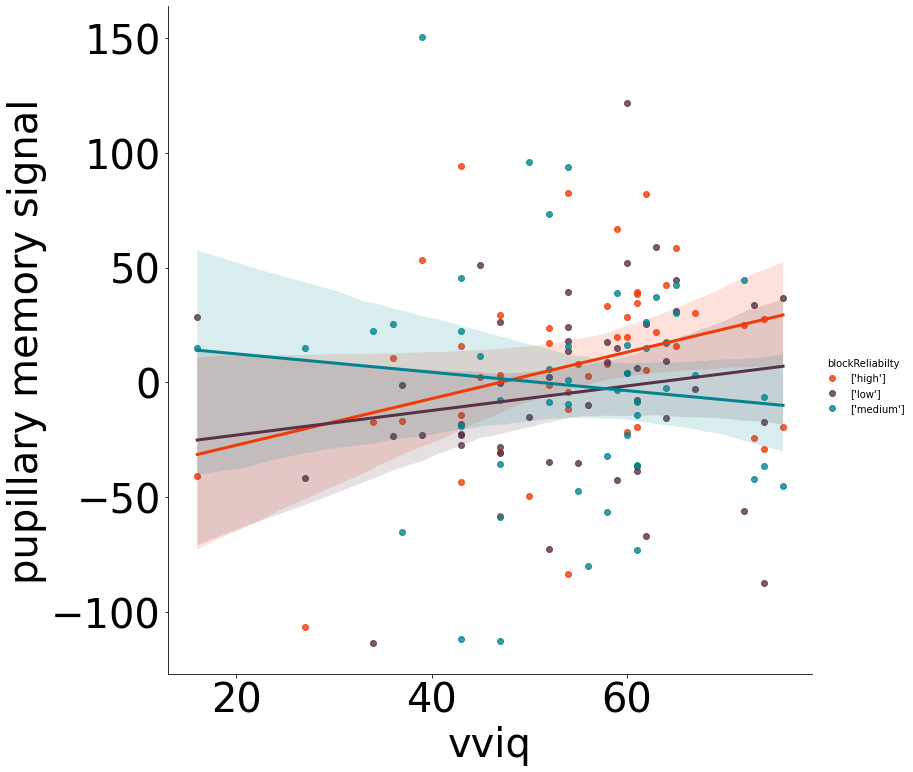

In [95]:
sns.lmplot(x = 'vviq',y = 'meanPup_delay',hue = 'blockReliabilty',palette=['#f23908',  '#593247','#03838f',],
                line_kws = dict(linewidth=3),
                data = tempDiff_blk,height = 10,aspect = 1)
plt.xlabel('vviq',fontsize = 40)
plt.ylabel('pupillary memory signal',fontsize = 40)
plt.tick_params(labelsize = 40)

## mixed model

In [96]:
tempDiff_blk['blockReliabilty'] = [ast.literal_eval(i)[0] for i in tempDiff_blk['blockReliabilty']]

In [97]:
model = smf.mixedlm("meanPup_delay ~  vviq + C(blockReliabilty,) + vviq:C(blockReliabilty,)",
                   re_formula='1+C(blockReliabilty,)',
                    data=tempDiff_blk,
                    groups= "subj").fit()

model.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                                     Mixed Linear Model Regression Results
===============================================================================================================
Model:                              MixedLM                  Dependent Variable:                  meanPup_delay
No. Observations:                   147                      Method:                              REML         
No. Groups:                         49                       Scale:                               1266.0113    
Min. group size:                    3                        Log-Likelihood:                      -749.3920    
Max. group size:                    3                        Converged:                           Yes          
Mean group size:                    3.0                                                                        
---------------------------------------------------------------------------------------------------------------
                                                                  Coef.   Std.Err.   z    P>|z|  [0.025  0.975]
---------------------------------------------------------------------------------------------------------------
Intercept                                                         -47.616   24.970 -1.907 0.057 -96.556   1.325
C(blockReliabilty, )[T.low]                                        13.956   37.883  0.368 0.713 -60.293  88.205
C(blockReliabilty, )[T.medium]                                     68.076   39.978  1.703 0.089 -10.280 146.432
vviq                                                                1.013    0.448  2.263 0.024   0.136   1.891
vviq:C(blockReliabilty, )[T.low]                                   -0.478    0.679 -0.703 0.482  -1.809   0.854
vviq:C(blockReliabilty, )[T.medium]                                -1.414    0.717 -1.972 0.049  -2.819  -0.009
subj Var                                                          211.580                                      
subj x C(blockReliabilty, )[T.low] Cov                           -326.779                                      
C(blockReliabilty, )[T.low] Var                                   868.955                                      
subj x C(blockReliabilty, )[T.medium] Cov                        -103.220                                      
C(blockReliabilty, )[T.low] x C(blockReliabilty, )[T.medium] Cov  190.728                                      
C(blockReliabilty, )[T.medium] Var                               1255.583                                      
===============================================================================================================

"""

# behavior plots

In [98]:
psyFull.shape

(14310, 205)

In [47]:
#get the aveage rt and response error
rtSubj = psyFull.groupby(['blk_validity','cue_condition','participant']).rt.mean().reset_index(drop = False)
memoryErrorSubj = psyFull.groupby(['blk_validity','cue_condition','participant']).abs_distance_to_probed_item.mean().reset_index(drop = False)


#for memory and rt, the diff between valid &invalid, for high/med/low
errorDiff = memoryErrorSubj.sort_values(by =['participant','blk_validity']).reset_index(drop = True)

temp = pd.DataFrame(errorDiff.iloc[::2].abs_distance_to_probed_item.values - errorDiff[1::2].abs_distance_to_probed_item.values)
temp[['blk_validity','participant']] = errorDiff.iloc[::2][['blk_validity','participant']].values
temp = temp.rename(columns={0:'memory'})

rtDiff = rtSubj.sort_values(by =['participant','blk_validity']).reset_index(drop = True)

tempRT = pd.DataFrame(rtDiff.iloc[::2].rt.values - rtDiff[1::2].rt.values)
tempRT[['blk_validity','participant']] = rtDiff.iloc[::2][['blk_validity','participant']].values
tempRT = tempRT.rename(columns={0:'rt'})


## stats

In [48]:
#t test, rt and memory error - welch t test since not equal variance
print('rt difference, high',stats.ttest_ind(rtSubj[(rtSubj.blk_validity== 'high')&(rtSubj.cue_condition== 'valid')].rt,
               rtSubj[(rtSubj.blk_validity== 'high')&(rtSubj.cue_condition== 'invalid')].rt,equal_var = False)),
print('rt difference, medium',stats.ttest_ind(rtSubj[(rtSubj.blk_validity== 'medium')&(rtSubj.cue_condition== 'valid')].rt,
               rtSubj[(rtSubj.blk_validity== 'medium')&(rtSubj.cue_condition== 'invalid')].rt,equal_var = False))
print('rt difference, low',stats.ttest_ind(rtSubj[(rtSubj.blk_validity== 'low')&(rtSubj.cue_condition== 'valid')].rt,
               rtSubj[(rtSubj.blk_validity== 'low')&(rtSubj.cue_condition== 'invalid')].rt,equal_var = False))

rt difference, high Ttest_indResult(statistic=-2.601892149169789, pvalue=0.010851531885270901)
rt difference, medium Ttest_indResult(statistic=-1.8284637784704263, pvalue=0.0706250862539714)
rt difference, low Ttest_indResult(statistic=-1.8369855278612275, pvalue=0.06931857259735785)


In [49]:
#t test for error
print('error difference, high',stats.ttest_ind(memoryErrorSubj[(memoryErrorSubj.blk_validity== 'high')&(memoryErrorSubj.cue_condition== 'valid')].abs_distance_to_probed_item,
               memoryErrorSubj[(memoryErrorSubj.blk_validity== 'high')&(memoryErrorSubj.cue_condition== 'invalid')].abs_distance_to_probed_item,equal_var = False)),
print('error difference, high',stats.ttest_ind(memoryErrorSubj[(memoryErrorSubj.blk_validity== 'medium')&(memoryErrorSubj.cue_condition== 'valid')].abs_distance_to_probed_item,
               memoryErrorSubj[(memoryErrorSubj.blk_validity== 'medium')&(memoryErrorSubj.cue_condition== 'invalid')].abs_distance_to_probed_item,equal_var = False))
print('error difference, high',stats.ttest_ind(memoryErrorSubj[(memoryErrorSubj.blk_validity== 'low')&(memoryErrorSubj.cue_condition== 'valid')].abs_distance_to_probed_item,
               memoryErrorSubj[(memoryErrorSubj.blk_validity== 'low')&(memoryErrorSubj.cue_condition== 'invalid')].abs_distance_to_probed_item,equal_var = False))

error difference, high Ttest_indResult(statistic=-4.178410615155082, pvalue=8.851895121186711e-05)
error difference, high Ttest_indResult(statistic=-3.752149616464556, pvalue=0.0003280374112055534)
error difference, high Ttest_indResult(statistic=-3.008187930329657, pvalue=0.0034231604693353863)


In [50]:
#anova
aovrm2way = AnovaRM(memoryErrorSubj, 'abs_distance_to_probed_item', 'participant', within=['cue_condition', 'blk_validity'])
res2way = aovrm2way.fit()
res2way.summary()

,F Value,Num DF,Den DF,Pr > F
cue_condition,62.0206,1.0000,48.0000,0.0000
blk_validity,1.8172,2.0000,96.0000,0.1680
cue_condition:blk_validity,3.4343,2.0000,96.0000,0.0363


In [51]:
pg.rm_anova(data =memoryErrorSubj, dv = 'abs_distance_to_probed_item',
    within = ['cue_condition', 'blk_validity'],subject = 'participant',
    effsize = 'np2')

,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,np2,eps
0,cue_condition,2565.825623,1,48,2565.825623,62.020602,3.399773e-10,3.399773e-10,0.563718,1.000000
1,blk_validity,85.281460,2,96,42.640730,1.817189,1.680262e-01,1.753228e-01,0.036477,0.820763
2,cue_condition * blk_validity,157.524012,2,96,78.762006,3.434329,3.626031e-02,4.734500e-02,0.066771,0.799906


In [52]:
aovrm2way = AnovaRM(rtSubj, 'rt', 'participant', within=['cue_condition', 'blk_validity'])
res2way = aovrm2way.fit()
res2way.summary()

,F Value,Num DF,Den DF,Pr > F
cue_condition,42.0227,1.0000,48.0000,0.0000
blk_validity,2.1685,2.0000,96.0000,0.1199
cue_condition:blk_validity,2.1351,2.0000,96.0000,0.1238


In [53]:
pg.rm_anova(data =rtSubj, dv = 'rt',
    within = ['cue_condition', 'blk_validity'],subject = 'participant',
    effsize = 'np2')

,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,np2,eps
0,cue_condition,0.676709,1,48,0.676709,42.022713,4.575106e-08,4.575106e-08,0.466801,1.000000
1,blk_validity,0.068229,2,96,0.034115,2.168525,1.199155e-01,1.302742e-01,0.043225,0.818941
2,cue_condition * blk_validity,0.030350,2,96,0.015175,2.135069,1.238175e-01,1.376961e-01,0.042586,0.752997


# signed err avg

In [54]:
fs(21,7)

Text(0.5, 42.0, 'Low')

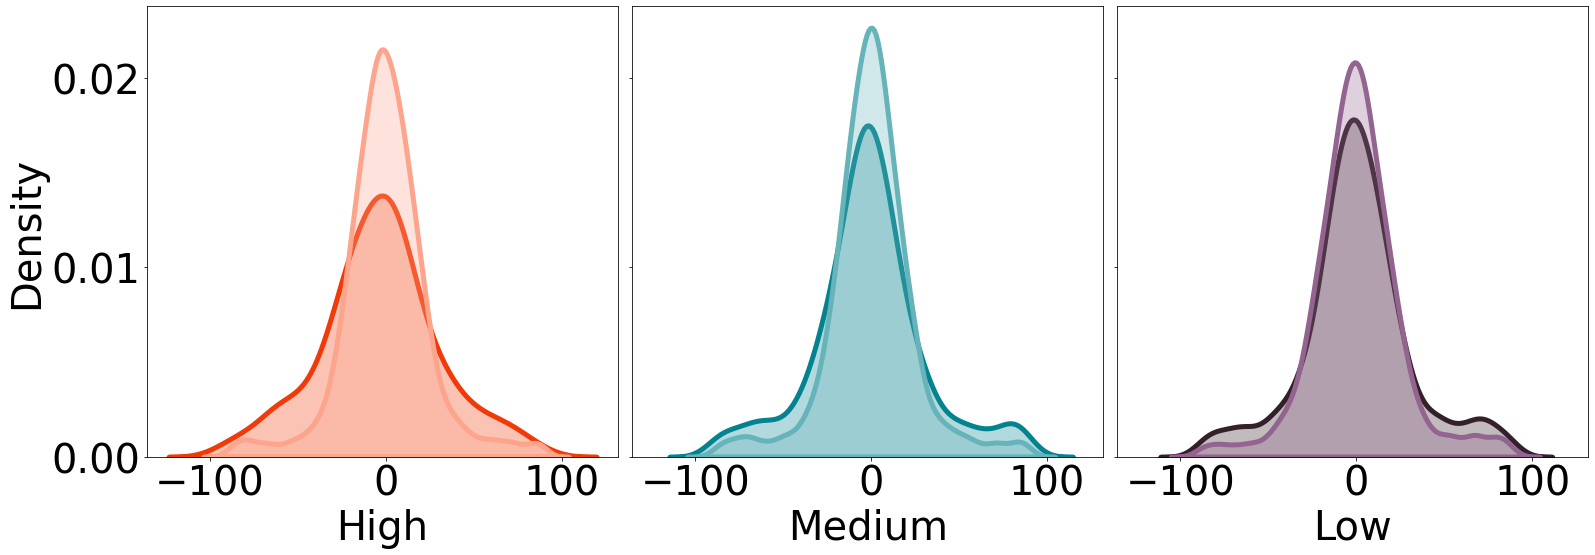

In [55]:
fig,ax = plt.subplots(ncols = 3,sharex=True, sharey=True)
sns.kdeplot(x = 'rel_distance_to_probed_item',hue = 'cue_condition',
            fill=True, common_norm=False, palette=['#fda48c','#f23908',],
            alpha=.3, linewidth=5,
            data = psyFull[psyFull['blk_validity'] == 'high'],ax = ax[0],)

ax[0].get_legend().set_visible(False)

sns.kdeplot(x = 'rel_distance_to_probed_item',hue = 'cue_condition',
            fill=True, common_norm=False, palette=['#66b3ba','#03838f',],
            alpha=.3, linewidth=5,
            data = psyFull[psyFull['blk_validity'] == 'medium'],ax = ax[1])
ax[1].get_legend().set_visible(False)

sns.kdeplot(x = 'rel_distance_to_probed_item',hue = 'cue_condition',
            fill=True, common_norm=False, palette=['#93648f', '#33202a'],
            alpha=.3, linewidth=5,
            data = psyFull[psyFull['blk_validity'] == 'low'],ax = ax[2])
ax[2].get_legend().set_visible(False)
           
fig.tight_layout()
[ax[i].tick_params( labelsize=40) for i in range(3) ]
ax[0].yaxis.set_major_locator(ticker.MultipleLocator(0.01))

ax[0].set_ylabel('Density',fontsize = 40)
ax[0].set_xlabel('High',fontsize = 40)
ax[1].set_xlabel('Medium',fontsize = 40)
ax[2].set_xlabel('Low',fontsize = 40)



## subj avg error plots

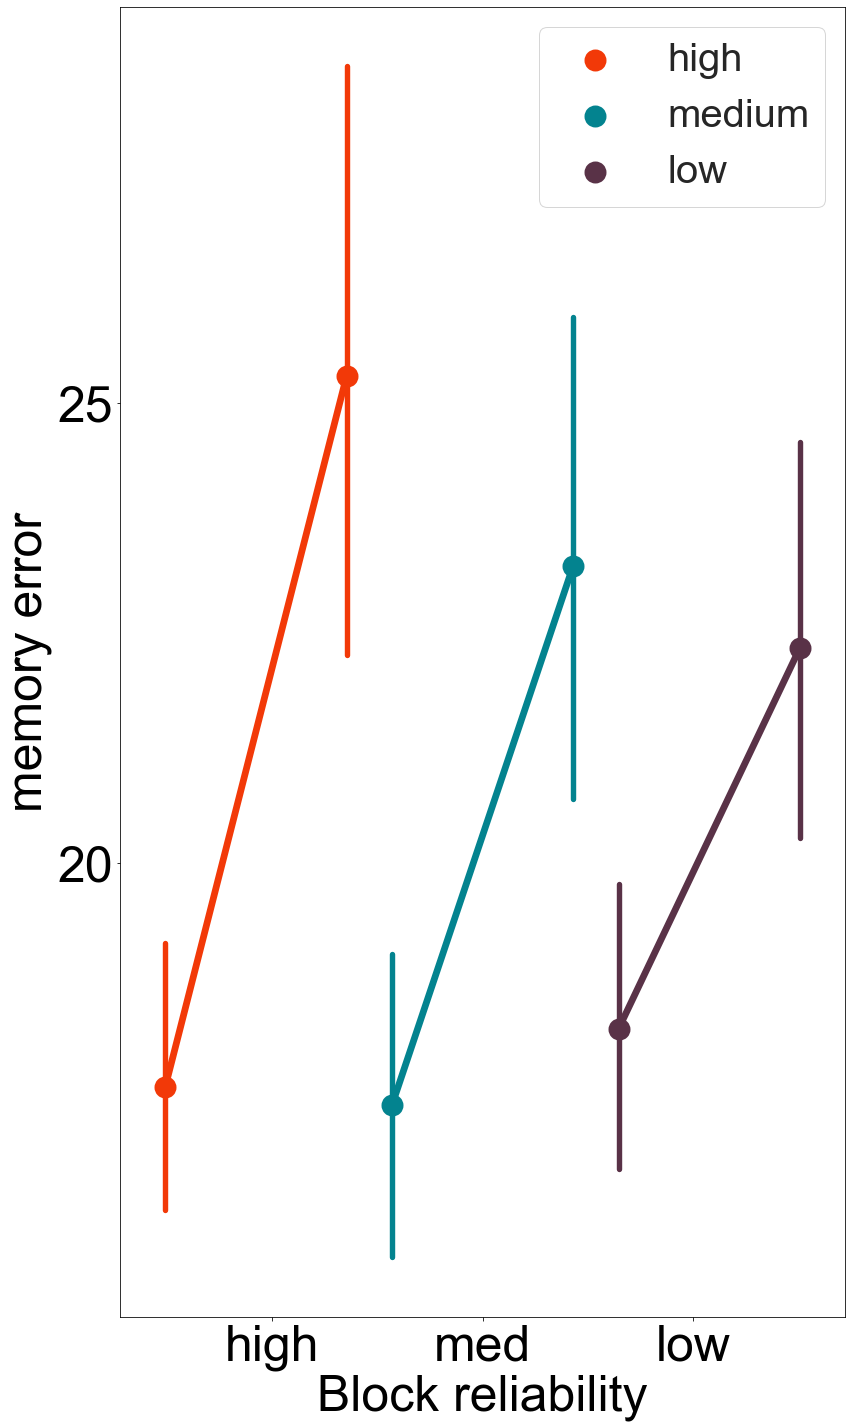

In [56]:
fig,ax = plt.subplots(figsize=(12,20))
sns.set(style="ticks", rc={"lines.linewidth": 3})

sns.pointplot(hue = 'blk_validity',x ='cue_condition' ,y = 'abs_distance_to_probed_item',dodge=2.5,
              order=['valid','invalid'], hue_order = ["high",'medium',"low"],scale = 1.25,
           palette=cDict.values(),data = memoryErrorSubj)#




ax.set(xlim=(-1.5,2.5))
ax.yaxis.set_major_locator(ticker.MultipleLocator(5))

plt.legend(prop={'size': 40}) 
plt.xlabel('Block reliability', fontsize=50)
plt.xticks(ticks = [-0.66,0.5,1.66], labels = ['high','med','low'])
plt.ylabel('memory error', fontsize=50)

plt.xticks(fontsize=50, )
plt.yticks(fontsize=50, )
fig.tight_layout()
plt.show()

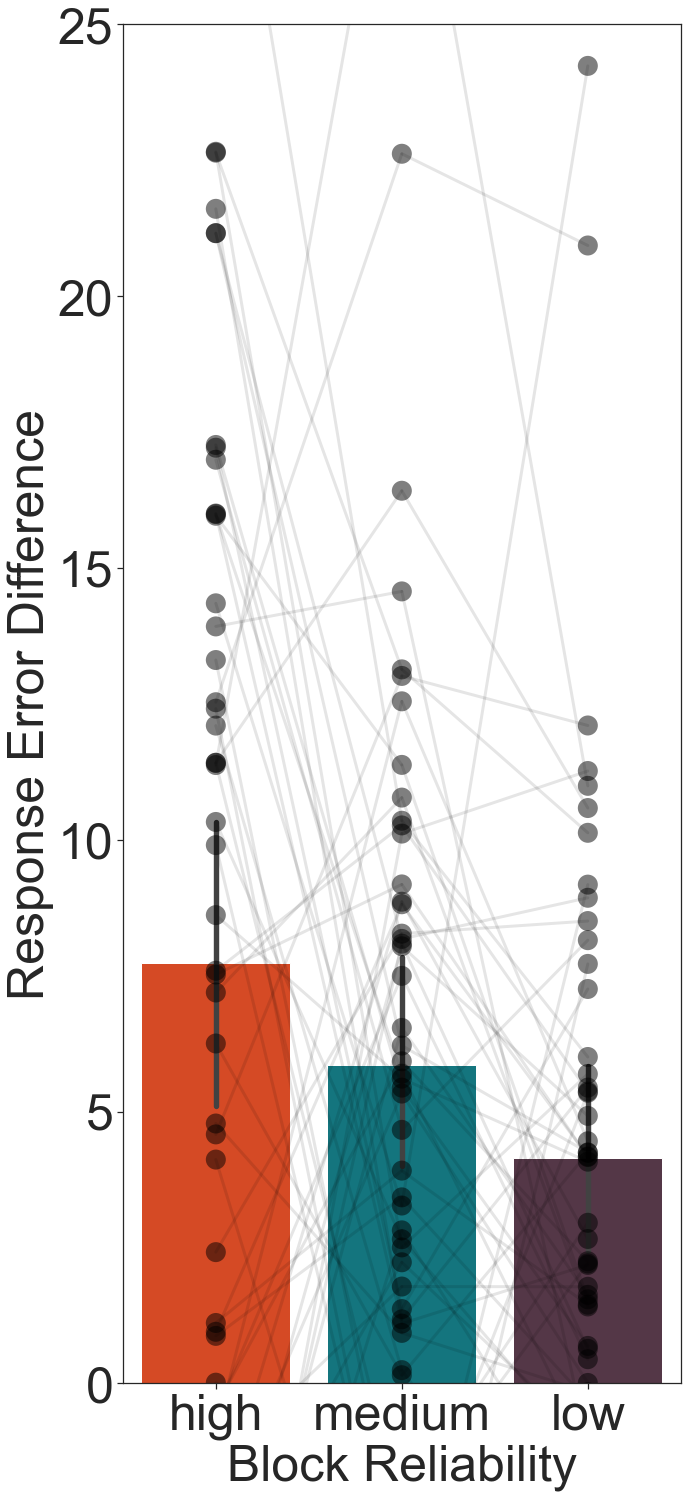

In [57]:
fs(9,15)
cDict = {"['high']":'#f23908',"['medium']":'#03838f',"['low']":'#593247'} #{"['high']":'red',"['medium']":'green',"['low']":'blue'}

fig,ax = plt.subplots(nrows = 1,figsize=(10,25))


sns.stripplot(x = 'blk_validity',y ='memory',order = ["high",'medium',"low"],
                data = temp,s = 20,palette=['black'],zorder=10, marker = "o",jitter=False,alpha = .5)

locs1 = ax.get_children()[0].get_offsets().data
locs2 = ax.get_children()[1].get_offsets().data
locs3 = ax.get_children()[2].get_offsets().data

for i in range(locs1.shape[0]):
    x = [locs1[i, 0], locs2[i, 0]]
    y = [locs1[i, 1], locs2[i, 1]]
    ax.plot(x, y, color="black", alpha=0.1)

    x = [locs2[i, 0], locs3[i, 0]]
    y = [locs2[i, 1], locs3[i, 1]]
    
    ax.plot(x, y, color="black", alpha=0.1)



sns.barplot(x = 'blk_validity',y ='memory',
            order = ["high",'medium',"low"],ax = ax,
            palette=cDict.values(),data = temp,zorder = 0)
plt.xticks(fontsize=50, )
plt.yticks(fontsize=50, )
#plt.title('Subject Averaged Difference \n (invalid - valid)',size =35)
plt.xlabel('Block Reliability',size = 50)
plt.ylabel('Response Error Difference',size = 50)
plt.ylim(0,25)
plt.show()

# response to reviewer

In [58]:
#get the aveage rt and response error
rtSubj = psyFull.groupby(['cued_item','participant']).rt.mean().reset_index(drop = False)
memoryErrorSubj = psyFull.groupby(['cued_item','participant']).abs_distance_to_probed_item.mean().reset_index(drop = False)


#for memory and rt, the diff between valid &invalid, for high/med/low
errorDiff = memoryErrorSubj.sort_values(by =['participant','cued_item']).reset_index(drop = True)

temp = pd.DataFrame(errorDiff.iloc[::2].abs_distance_to_probed_item.values - errorDiff[1::2].abs_distance_to_probed_item.values)
temp['participant'] = errorDiff.iloc[::2][['participant']].values
temp = temp.rename(columns={0:'memory'})

rtDiff = rtSubj.sort_values(by =['participant']).reset_index(drop = True)

tempRT = pd.DataFrame(rtDiff.iloc[::2].rt.values - rtDiff[1::2].rt.values)
tempRT['participant'] = rtDiff.iloc[::2][['participant']].values
tempRT = tempRT.rename(columns={0:'rt'})


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


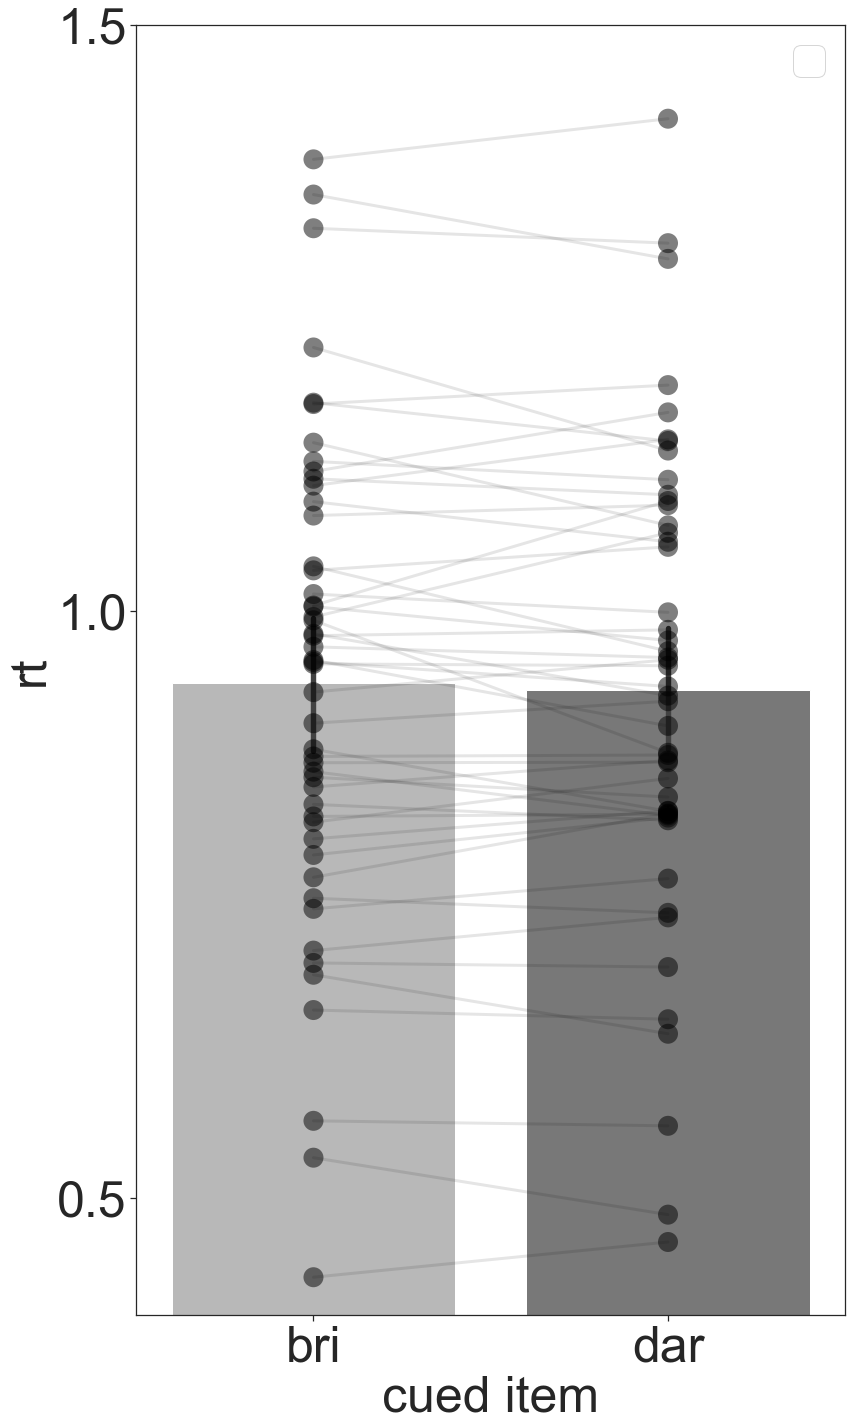

In [59]:
fig,ax = plt.subplots(figsize=(12,20))
sns.set(style="ticks", rc={"lines.linewidth": 3})
sns.stripplot(x = 'cued_item',y = 'rt',data = rtDiff,s = 20,palette=['black'],zorder=10, marker = "o",jitter=False,alpha = .5)


locs1 = ax.get_children()[0].get_offsets().data
locs2 = ax.get_children()[1].get_offsets().data

for i in range(locs1.shape[0]):
    x = [locs1[i, 0], locs2[i, 0]]
    y = [locs1[i, 1], locs2[i, 1]]
    ax.plot(x, y, color="black", alpha=0.1)
    

sns.barplot(x = 'cued_item',y = 'rt',data = rtDiff,
            palette=['#b8b8b8','#787878'])

plt.ylim(0.4,1.5)
ax.yaxis.set_major_locator(ticker.MultipleLocator(0.5))

plt.legend(prop={'size': 40}) 
plt.xlabel('cued item', fontsize=50)
plt.ylabel('rt', fontsize=50)

plt.xticks(fontsize=50, )
plt.yticks(fontsize=50, )
fig.tight_layout()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


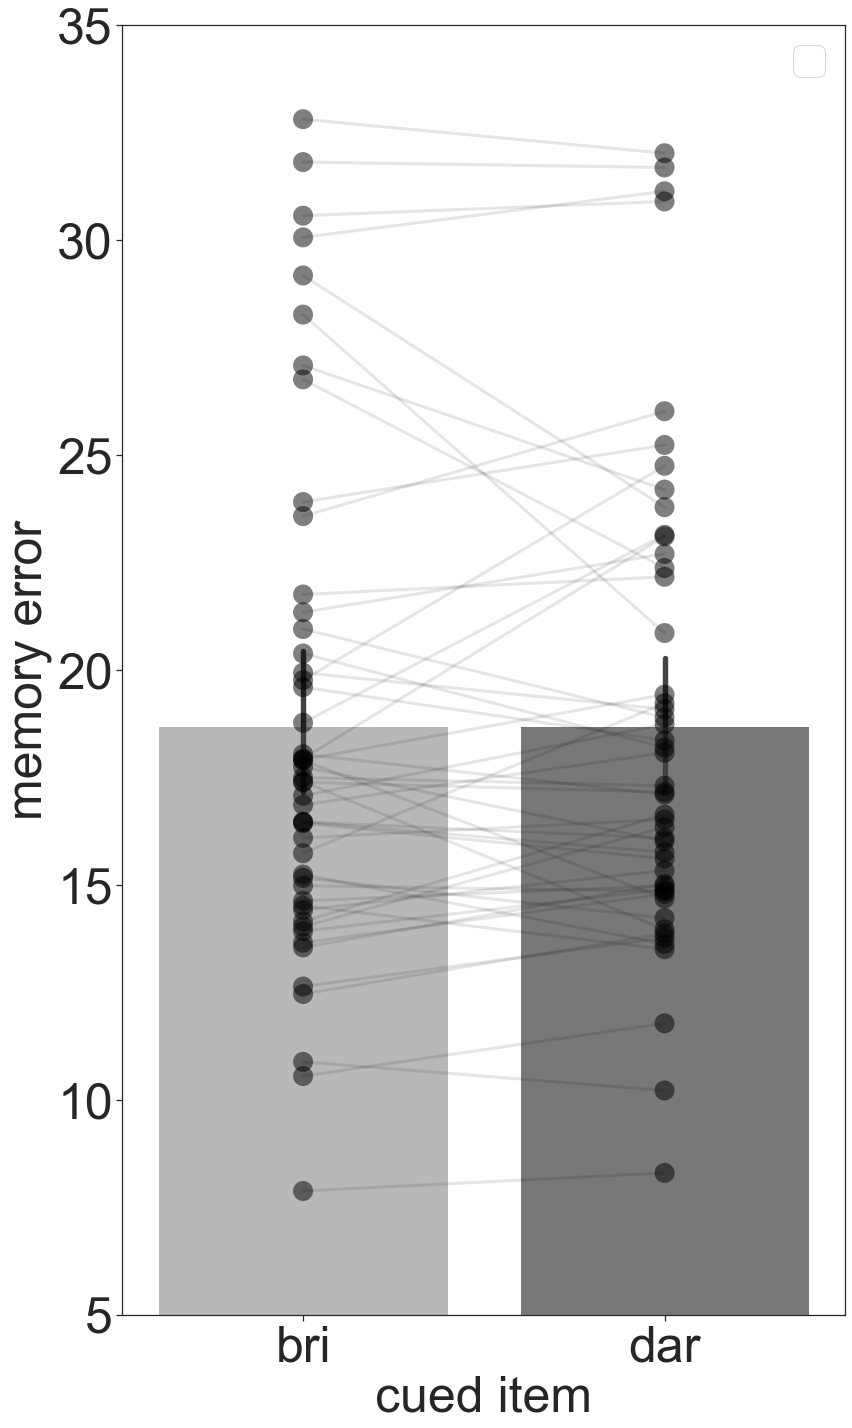

In [60]:
fig,ax = plt.subplots(figsize=(12,20))
sns.set(style="ticks", rc={"lines.linewidth": 3})
sns.stripplot(x = 'cued_item',y = 'abs_distance_to_probed_item',data = memoryErrorSubj,s = 20,
              palette=['black'],zorder=10, marker = "o",jitter=False,alpha = .5)


locs1 = ax.get_children()[0].get_offsets().data
locs2 = ax.get_children()[1].get_offsets().data

for i in range(locs1.shape[0]):
    x = [locs1[i, 0], locs2[i, 0]]
    y = [locs1[i, 1], locs2[i, 1]]
    ax.plot(x, y, color="black", alpha=0.1)
    

sns.barplot(x = 'cued_item',y = 'abs_distance_to_probed_item',data = memoryErrorSubj,
            palette=['#b8b8b8','#787878'])

plt.ylim(5,35)
ax.yaxis.set_major_locator(ticker.MultipleLocator(5))

plt.legend(prop={'size': 40}) 
plt.xlabel('cued item', fontsize=50)
plt.ylabel('memory error', fontsize=50)

plt.xticks(fontsize=50, )
plt.yticks(fontsize=50, )
fig.tight_layout()
plt.show()

In [61]:
stats.ttest_rel(rtDiff[rtDiff.cued_item == 'bri'].rt,
                rtDiff[rtDiff.cued_item == 'dar'].rt)

Ttest_relResult(statistic=1.0439562277716732, pvalue=0.30173492398765356)

In [62]:
#calculate cohen's D
briArr = rtDiff[rtDiff.cued_item == 'bri'].rt.values
darArr = rtDiff[rtDiff.cued_item == 'dar'].rt.values

#calculate pooled SD
df = len(briArr)-1
pooledSD = np.sqrt((df * np.var(briArr) + df*np.var(darArr))/(df*2))

#calculate cohenD
cohenD = np.mean(briArr-darArr)/pooledSD

print('rt - cohen',cohenD)


rt - cohen 0.030558104272849572


In [63]:
stats.ttest_rel(errorDiff[errorDiff.cued_item == 'bri'].abs_distance_to_probed_item,
                errorDiff[errorDiff.cued_item == 'dar'].abs_distance_to_probed_item)

Ttest_relResult(statistic=-0.01653153603832032, pvalue=0.9868788684526892)

In [64]:
#calculate cohen's D
briArr = errorDiff[errorDiff.cued_item == 'bri'].abs_distance_to_probed_item.values
darArr = errorDiff[errorDiff.cued_item == 'dar'].abs_distance_to_probed_item.values

#calculate pooled SD
df = len(briArr)-1
pooledSD = np.sqrt((df * np.var(briArr) + df*np.var(darArr))/(df*2))

#calculate cohenD
cohenD = np.mean(briArr-darArr)/pooledSD

print('rspErr - cohen',cohenD)

rspErr - cohen -0.0010144378577051497


In [70]:
#get the aveage response error
memoryErrorSubj = psyFull.groupby(['cue_condition','cued_item','participant']).abs_distance_to_probed_item.mean().reset_index(drop = False)


#the diff between valid &invalid
errorDiff = memoryErrorSubj.sort_values(by =['participant','cued_item']).reset_index(drop = True)
temp = pd.DataFrame(errorDiff.iloc[::2].abs_distance_to_probed_item.values - errorDiff[1::2].abs_distance_to_probed_item.values)
temp[['cued_item','participant']] = errorDiff.iloc[::2][['cued_item','participant']].values
temp = temp.rename(columns={0:'memory'})

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


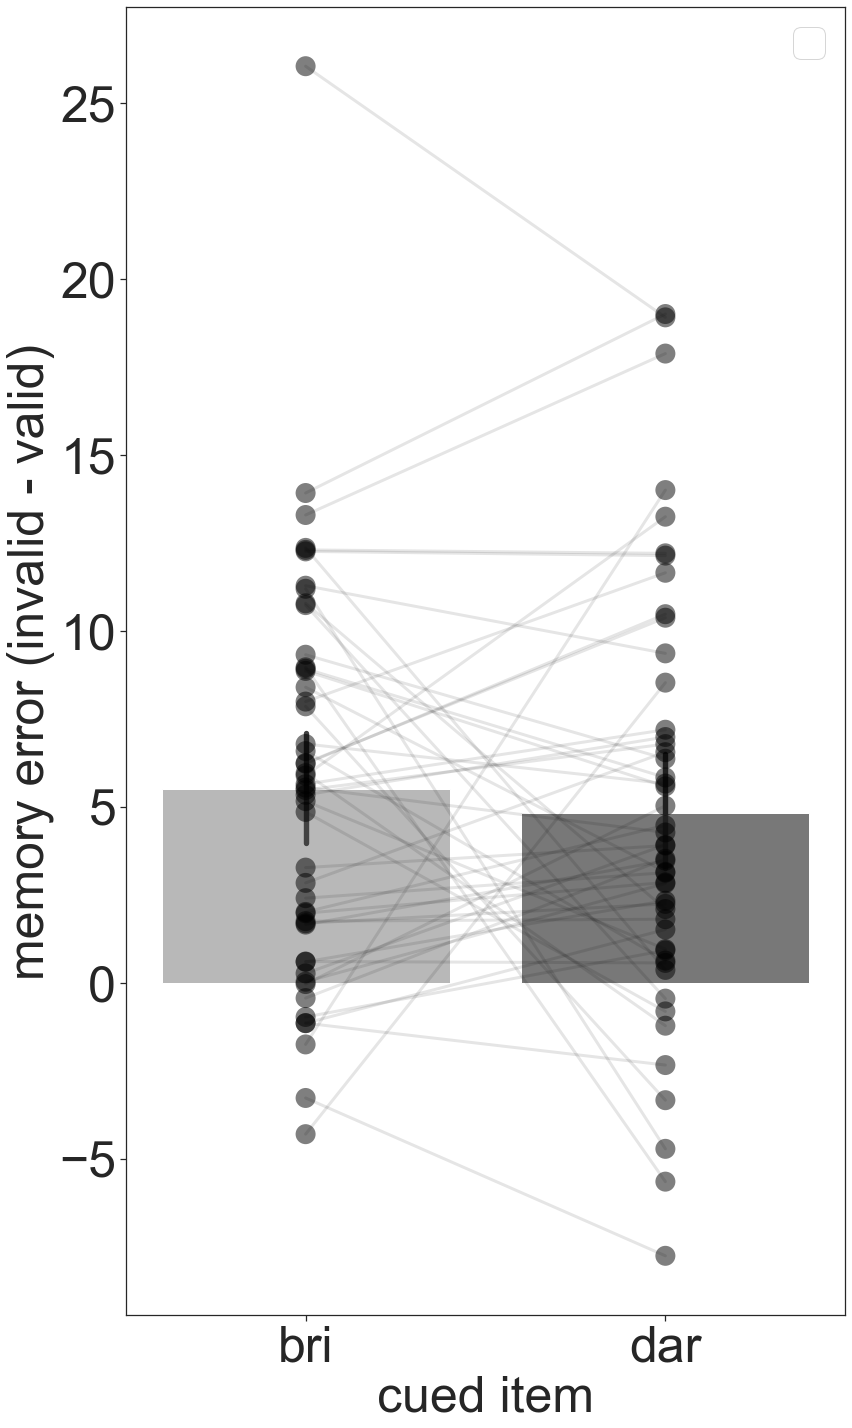

In [71]:
fig,ax = plt.subplots(figsize=(12,20))
sns.set(style="ticks", rc={"lines.linewidth": 3})
sns.stripplot(x = 'cued_item',y = 'memory',data = temp,s = 20,palette=['black'],zorder=10, marker = "o",jitter=False,alpha = .5)


locs1 = ax.get_children()[0].get_offsets().data
locs2 = ax.get_children()[1].get_offsets().data

for i in range(locs1.shape[0]):
    x = [locs1[i, 0], locs2[i, 0]]
    y = [locs1[i, 1], locs2[i, 1]]
    ax.plot(x, y, color="black", alpha=0.1)


sns.barplot(x = 'cued_item',y = 'memory',data = temp,palette=['#b8b8b8','#787878'])
#plt.ylim(15,22)
ax.yaxis.set_major_locator(ticker.MultipleLocator(5))

plt.legend(prop={'size': 40}) 
plt.xlabel('cued item', fontsize=50)
plt.ylabel('memory error (invalid - valid)', fontsize=50)

plt.xticks(fontsize=50, )
plt.yticks(fontsize=50, )
fig.tight_layout()
plt.show()

In [72]:
pg.rm_anova(data =memoryErrorSubj, dv = 'abs_distance_to_probed_item',
    within = ['cued_item', 'cue_condition'],subject = 'participant',
    effsize = 'np2')

,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,np2,eps
0,cued_item,1.518469,1,48,1.518469,0.158258,6.925295e-01,6.925295e-01,0.003286,1.0
1,cue_condition,1316.326680,1,48,1316.326680,55.146929,1.639060e-09,1.639060e-09,0.534644,1.0
2,cued_item * cue_condition,5.833576,1,48,5.833576,0.604192,4.407972e-01,4.407972e-01,0.012431,1.0
